In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings(action='once')

# Model Selection

For this part of the project, I am attempting to employ time series analysis of performance on multiple samples/players simultaneously. Due to the parrallel nature of this prediction, my options are reduced to some degree. After modeling pitcher and batter forecasting based on recent performance, the goal is to insert the results into another model along with additional information. The primary optionas are as follows:

* AR, MA, ARMA, ARIMA, SARIMA: These are the most traditional models, and will be worthwhile looking into.
* Holt-Winters: While not as commonly referenced as ARMA, this approach still sees decent use. It is the best version of Exponential Smoothing.
* VAR, VMA, and VARMA: These are adjustments to the traditional ARIMA model which allow for additional exogeneous variables. The main assumption is that different time series can affect each other. While this might be true for pitchers and batters, it is rather difficult to incorporate this. This could something I test later on when I fully assemble the model, but will be a test for this model at this stage as well.
* Hierarchical Forecasting: This follows grouping of like groups for each forecasting model it uses, but this is difficult to employ for a few reasons. One, the pitchers and batters themselves are difficult to cluster. This essentially follows a cluster of a cluster of a cluster approach, because pitch arsenals are represented by a soft cluster of individual pitcher repertoire clusters. While this is true, there might be a way to cluster performance rather than base the cluster off of pitches seen/thrown. Two, it is difficult to employ this strategy to pitchers who have no previous data. However, the largest cluster's or the most averaged cluster's model can be used in this situation. The main benefit of using this method is diversity in models. This would allow for more traditional models being used, such as ARIMA/SARIMA, TBATS, and Holt-Winters Forecasting.
* Random-Forest Approach: This method involves data manipulation to represent recent events. By including past target variables along with a rolling mean/max/min, we can use a random forest or other traditional regression model to predict the target variable. I can also use past feature variables to create a multivariate time series approach.
* Neural Nets: This is the most appealing to use, but because it is supposed to be good at finding patterns, I have to wonder about how much prior setup that I have done for other models and that I am currently doing that I can discard. While this seems like a good choice due to the high number of available variables, this would bypass much of the work I have already done. I would instead just insert the condensed versions of pitcher and batter condensed game files along with any other variables that are deemed correlated into the NN, making this step pointless. As such, Neural Nets such as Long-Short Term Memory (LSTM) are not ideal at this point in the process, because they will have no other completed models to compete against.
* Panel Data Approaches: The structure of the data is cross-sectional and time series. This means that the panel data approaches such as Pooled OLS, Fixed Effect, and Random Effect are tempting approaches as well. The unbalanced nature of the dataset will create some problems.

I will look into a few combinations of variables to insert into the model, all of which might influence the time series, and are not influenced by the time series itself. This includes the relevant player id, game date, and the target variable ('estimated_ba_using_speedangle'). Another option to include the home field, which would attempt to account for park factors. The question becomes whether to include this factor in at this step, for the final step. If this is included at this step, I should attempt to account for park factors in my model so I can get an accurate performance measurement.

# Model Problems

The main problems resides in the data. The data consists of many time series of varying lengths and has missing data that is meaningful due to it signifying an off-day/rest-day for the player.

## Many Time Series
Many of time series approaches are designed for a single time series dataset (ARIMA,VARMA, Holt-Winters, etc.). This means that there is no way to truly train any single model on all instances. However, hierarchical models,panel data approaches, the random forest approach, and neural nets all offer work arounds. I can still perform time series analysis in an effor to gleam some insight.

## Meaningfully Unbalanced Data
This is where things are difficult. Many approaches take in to account a moving average. I will try leaving these missing days out for some models, and entertain the idea of inserting '0' into the missing rows and including a 'play' columns that will signify whether a player played that day or not. This is because an off-day is very different from a '0' in this data set.

## Batters

I will start by forecasting batters. This involves condensing each pitch thrown into an atbat, where the clustered pitcher attributes are weighted. At this point in time, only the final pitch of the at bat is considered, as it is the most important pitch thrown. However, future versions of this model might involve inclusion of previous pitches in the atbat. Pitches thrown is also calculated.

Then atbats are condensed into game representation. This involves calculating an overall estimated batting average, which is the target variable of this exercise. This is calculated similar to actual batting average. Strikeouts count as 0.0, while walks, hit by pitch, and catcher intereference are not counted toward the estimated average. However, the main difference comes from handling of errors. In this model, the result of play is irrelevant, so all balls put into play are considered positively toward the average. This means that field outs and errors with high estimated batting average can still contribute poisitively toward the estimated batting average, while a ball that drops in for a hit might have the opposite effect. This score is based entirely on quality of contact and the likelihood that a hit is achieved.

In [4]:
train_set = pd.read_csv('data/train/batters_condensed_train.csv')
test_set = pd.read_csv('data/test/batters_condensed_test.csv')

In [5]:
train_set.fillna(0, inplace=True)
test_set.fillna(0, inplace=True)

In [6]:
team_list = list(train_set.home_team.unique())

train_set['home_team'] = train_set['home_team'].apply(lambda x: team_list.index(x)+1)
train_set = train_set.reindex()

test_set['home_team'] = test_set['home_team'].apply(lambda x: team_list.index(x)+1)
test_set = test_set.reindex()

In [7]:
endog = ['estimated_ba_using_speedangle']
exog = ['home_team','bb','k','pa']

model_col = endog.copy()
model_col.extend(exog)
model_col.append('game_date')
model_col.append('batter')

In [8]:
train_set[endog] = train_set[endog].astype('float')
train_set['game_date'] = train_set['game_date'].apply(pd.to_datetime)

test_set[endog] = test_set[endog].astype('float')
test_set['game_date'] = test_set['game_date'].apply(pd.to_datetime)

for col in exog:
    train_set[col] = train_set[col].astype('int')
    test_set[col] = test_set[col].astype('int')
    
train_set['batter'] = train_set['batter'].astype('int')
test_set['batter'] = test_set['batter'].astype('int')

train_set['pitcher'] = train_set['pitcher'].astype('int')
test_set['pitcher'] = test_set['pitcher'].astype('int')

In [9]:
train = train_set[model_col].copy()
test = test_set[model_col].copy()

In [10]:
train_set['play'] = train_set['pa'].apply(lambda x: 1 if x>0 else 0)
test_set['play'] = test_set['pa'].apply(lambda x: 1 if x>0 else 0)

Next, lets make the date_time the index for ease of use when performing time series analysis and save the files.

### Data Preparation

The Addley-Fuller Test will be employed to ensure stationary data. While expect the data to be stationary, it is still best to check. This is a requirement for many time series models.

In [11]:
batters_limit = []
batters = list(train_set.batter.unique())
batters.extend(test_set.batter.unique())

for batter in batters:
    if len(train_set[train_set.batter == batter].index) > 100:
        batters_limit.append(batter)

In [12]:
p_vals = []

for batter in batters:
    temp_df = train_set[train_set.batter == batter]['estimated_ba_using_speedangle']
    if len(temp_df.index) > 100:
        adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(temp_df)
        p_vals.append(pval)

In [13]:
print("max p-value: " + str(max(p_vals)))
print("min p-value: " + str(min(p_vals)))

max p-value: 0.41924603998337384
min p-value: 0.0


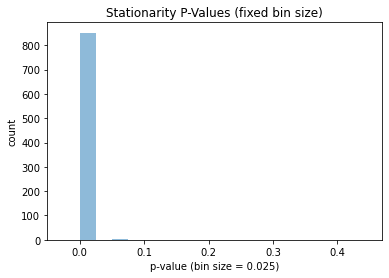

In [14]:
bins = np.arange(0, 1, 0.025) # fixed bin size

plt.xlim([min(p_vals)-0.05, max(p_vals)+0.05])

plt.hist(p_vals, bins=bins, alpha=0.5)
plt.title('Stationarity P-Values (fixed bin size)')
plt.xlabel('p-value (bin size = 0.025)')
plt.ylabel('count')

plt.show()

As expected, this data is fully stationary. There does appear to be a few cases where stationarity is not upheld, but because it is the vast minority, I am willing to assume that it is stationary and will proceed.

# Random Forest Approach

## Prep Data

In [137]:
cols_rf = ['game_date','batter','bb','k','home_team','estimated_ba_using_speedangle','pa', 'play']

rf_train = train_set[cols_rf].copy()
rf_test = test_set[cols_rf].copy()

In [138]:
rf_train = rf_train.sort_values('game_date')
rf_test = rf_test.sort_values('game_date')

In [139]:
rf_train['game_date'] = pd.to_datetime(rf_train['game_date'])
rf_train = rf_train.set_index('game_date')

rf_test['game_date'] = pd.to_datetime(rf_test['game_date'])
rf_test = rf_test.set_index('game_date')

In [140]:
pd_out = pd.DataFrame()

for batter in rf_train.batter.unique():
    temp_df = rf_train[rf_train.batter == batter]
    pd_out = pd_out.append(temp_df.asfreq('D'))
    pd_out['batter'].fillna(batter, inplace=True)

In [141]:
pd_test_out = pd.DataFrame()

for batter in rf_test.batter.unique():
    temp_df = rf_test[rf_test.batter == batter]
    pd_test_out = pd_test_out.append(temp_df.asfreq('D'))
    pd_test_out['batter'].fillna(batter, inplace=True)

In [142]:
pd_out.fillna(0,inplace=True)
pd_test_out.fillna(0,inplace=True)

In [143]:
def shift_target(data):
    data[['next_estimated_ba_using_speedangle','next_play','next_home_team']] = data.groupby('batter')[['estimated_ba_using_speedangle','play','home_team']].shift(-1)

In [144]:
shift_target(pd_out)
pd_out.dropna(inplace=True)

shift_target(pd_test_out)
pd_test_out.dropna(inplace=True)

In [145]:
def per_pa(data):
    mask = (data.pa != 0)
    data.loc[mask,'k_per_pa'] = data.loc[mask,'k'] / data.loc[mask,'pa']
    data.loc[mask,'bb_per_pa'] = data.loc[mask,'bb'] / data.loc[mask,'pa']
    
    data[['k_per_pa','bb_per_pa']] = data[['k_per_pa','bb_per_pa']].fillna(0)

In [146]:
per_pa(pd_out)
per_pa(pd_test_out)

In [147]:
def date_info(data):
    day_of_week_idx = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
    
    data['day_of_week'] = data.index.day_name()
    data['day_of_week'] = data.day_of_week.replace(day_of_week_idx)
    
    data['month'] = data.index.month
    data['year'] = data.index.year

In [148]:
date_info(pd_out)
date_info(pd_test_out)

In [149]:
pd_out[['batter','month','year','day_of_week','next_home_team','home_team']] = pd_out[['batter','month','year','day_of_week','next_home_team','home_team']].astype('int')
pd_test_out[['batter','month','year','day_of_week','next_home_team','home_team']] = pd_test_out[['batter','month','year','day_of_week','next_home_team','home_team']].astype('int')

In [150]:
pd_out.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 860806 entries, 2017-04-02 to 2020-09-26
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   batter                              860806 non-null  int32  
 1   bb                                  860806 non-null  float64
 2   k                                   860806 non-null  float64
 3   home_team                           860806 non-null  int32  
 4   estimated_ba_using_speedangle       860806 non-null  float64
 5   pa                                  860806 non-null  float64
 6   play                                860806 non-null  float64
 7   next_estimated_ba_using_speedangle  860806 non-null  float64
 8   next_play                           860806 non-null  float64
 9   next_home_team                      860806 non-null  int32  
 10  k_per_pa                            860806 non-null  float64
 11  bb_per_pa 

In [151]:
df_train = pd_out.copy()
df_test = pd_test_out.copy()

In [152]:
def rolling_data(data,roll_amount,target):
    mean_name = target + '_mean_' + str(roll_amount)
    days_off_name = 'days_off_' + str(roll_amount)
    
    temp_df = data.groupby('batter')[[target,'play']].rolling(roll_amount).sum().reset_index(level=0,drop=False)
    temp_df.columns = ['batter', target, 'play']
    
    mask = (temp_df.play != 0)
    temp_df.loc[mask,mean_name] = temp_df.loc[mask,target] / temp_df.loc[mask,'play']
    
    temp_df[days_off_name] = temp_df['play'].apply(lambda x: roll_amount - x)
    
    temp_df = temp_df.drop([target,'play'],axis = 1)
    
    return data.merge(temp_df, on=['game_date','batter'])

In [153]:
def rolling_weighted_data(data,roll_amount,target):
    data['weighted_pa'] = data.pa - data.bb
    data['weighted_target'] = data[target] * data.weighted_pa
    
    name = target + '_mean_weighted_' + str(roll_amount)
    
    temp_df = data.groupby('batter')[['weighted_target','weighted_pa']].rolling(roll_amount).sum().reset_index(level=0,drop=False)
    
    mask = (temp_df.weighted_pa != 0)
    temp_df.loc[mask,name] = temp_df.loc[mask,'weighted_target'] / temp_df.loc[mask,'weighted_pa']
    
    temp_df = temp_df.drop(['weighted_target','weighted_pa'],axis = 1)
    
    return data.merge(temp_df, on=['game_date','batter'], how='inner')

In [154]:
roll_vars = ['estimated_ba_using_speedangle','k_per_pa','bb_per_pa']

for item in roll_vars:
    for i in range(3):
        depth = (i+1) * 5
        
        df_train = rolling_data(df_train,depth,item)
        df_train = rolling_weighted_data(df_train,depth,item)

In [155]:
def lag_features(data,n):
    cols = ['bb_per_pa','k_per_pa','play','estimated_ba_using_speedangle']
    
    for col in cols:
        for i in range(n):
            name = col + '_' + str(i+1)
            
            if i > 0:
                prev_name = col + '_' + str(i)
                data[name] = data.groupby('batter')[prev_name].shift(1)
            else:
                data[name] = data.groupby('batter')[col].shift(1)
                
    return data

In [156]:
lag_features(df_train,15)

,batter,bb,k,home_team,estimated_ba_using_speedangle,pa,play,next_estimated_ba_using_speedangle,next_play,next_home_team,...,estimated_ba_using_speedangle_6,estimated_ba_using_speedangle_7,estimated_ba_using_speedangle_8,estimated_ba_using_speedangle_9,estimated_ba_using_speedangle_10,estimated_ba_using_speedangle_11,estimated_ba_using_speedangle_12,estimated_ba_using_speedangle_13,estimated_ba_using_speedangle_14,estimated_ba_using_speedangle_15
game_date,,,,,,,,,,,,,,,,,,,,,
2017-04-02,575929,0.0,2.0,12,0.356500,3.0,1.0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-03,575929,0.0,0.0,0,0.000000,0.0,0.0,0.260000,1.0,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-04,575929,1.0,2.0,12,0.260000,3.0,1.0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-05,575929,0.0,0.0,0,0.000000,0.0,0.0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-06,575929,0.0,0.0,0,0.000000,0.0,0.0,0.220000,1.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,666931,0.0,0.0,20,0.351000,1.0,1.0,0.290000,1.0,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-24,666931,0.0,1.0,20,0.290000,3.0,1.0,0.061500,1.0,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-25,666931,0.0,2.0,18,0.061500,3.0,1.0,0.000000,1.0,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
def depth_features(data,depth,roll_vars=['estimated_ba_using_speedangle','k_per_pa','bb_per_pa']):
    temp_df = data.copy()
    for item in roll_vars:
        for i in range(1,depth+1):
            if i % 5 == 0:
                temp_df = rolling_data(temp_df,i,item)
                temp_df = rolling_weighted_data(temp_df,i,item)
    temp_df = lag_features(temp_df,depth)
    
    return temp_df

In [158]:
def mape(y_true,y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    ape[~np.isfinite(ape)] = 1
    return np.mean(ape)

def wape(y_true,y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [159]:
mean_features = []
target_var = 'next_estimated_ba_using_speedangle'

for col in df_train.columns:
    if 'estimated_ba_using_speedangle' in col:
        mean_features.append(col)
        
mean_features.remove(target_var)

In [164]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [174]:
mask = (df_train.pa != 0)
y_true = df_train.loc[mask,target_var]
outcomes = {}

for feature in mean_features:
    mask = (df_train[feature].notna())
    y_true = df_train.loc[mask,target_var]
    y_pred = df_train.loc[mask,feature]
    outcomes[feature] = {'mape': mape(y_true,y_pred),
                         'wape': wape(y_true,y_pred),
                         'mse': mean_squared_error(y_true, y_pred),
                         'mae': mean_absolute_error(y_true, y_pred)}

In [176]:
outcomes

{'estimated_ba_using_speedangle': {'mape': 1.1652830886473193,
  'wape': 1.144526992732113,
  'mse': 0.018154257457518076,
  'mae': 0.052127719759147574},
 'estimated_ba_using_speedangle_mean_5': {'mape': 1.605252419559167,
  'wape': 1.2784084201362733,
  'mse': 0.049769598601938844,
  'mae': 0.17326620704987292},
 'estimated_ba_using_speedangle_mean_weighted_5': {'mape': 1.6561844543246103,
  'wape': 1.3026456756555584,
  'mse': 0.05111129253893271,
  'mae': 0.17692563368935185},
 'estimated_ba_using_speedangle_mean_10': {'mape': 1.5292472334081937,
  'wape': 1.3662445618079024,
  'mse': 0.0454112486466742,
  'mae': 0.1699656971442761},
 'estimated_ba_using_speedangle_mean_weighted_10': {'mape': 1.5838103233895209,
  'wape': 1.4057663509187366,
  'mse': 0.04732688492450129,
  'mae': 0.1751583202250753},
 'estimated_ba_using_speedangle_mean_15': {'mape': 1.4932621140649454,
  'wape': 1.446313757779624,
  'mse': 0.043821616883045554,
  'mae': 0.16974688463963875},
 'estimated_ba_using_s

In [40]:
feature_var = [col for col in df_train.columns if col != target_var]
feature_var.remove('batter')

## Random Forest Model

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
df_train_final = df_train.dropna()
mask = (df_train_final.pa != 0)

In [43]:
model_rf = RandomForestRegressor()
model_rf.fit(df_train_final[feature_var],df_train_final[target_var])

RandomForestRegressor()

In [44]:
model_rf_condensed = RandomForestRegressor()
model_rf_condensed.fit(df_train_final[mask][feature_var],df_train_final[mask][target_var])

RandomForestRegressor()

In [45]:
pred_rf = model_rf.predict(df_train_final[feature_var])
pred_rf_condensed = model_rf_condensed.predict(df_train_final[feature_var])

In [46]:
df_train_final.loc[:,'pred_y'] = pred_rf
df_train_final.loc[:,'pred_yc'] = pred_rf_condensed

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [47]:
y_true = df_train_final.loc[mask,target_var]
y_pred = df_train_final.loc[mask,'pred_y']
y_pred_c = df_train_final.loc[mask,'pred_yc']

In [48]:
print('Included off days')
print('MAPE: ' + str(mape(y_true,y_pred)))
print('WAPE: ' + str(wape(y_true,y_pred)))
print('Off days filtered')
print('MAPE: ' + str(mape(y_true,y_pred_c)))
print('WAPE: ' + str(wape(y_true,y_pred_c)))

Included off days
MAPE: 0.8620068046227454
WAPE: 0.21763817595318485
Off days filtered
MAPE: 0.8609003314091982
WAPE: 0.21765800200976687


In [49]:
feature_importance = {}

for i in range(len(df_train[feature_var].columns)):
    feature_importance[df_train[feature_var].columns[i]] = model_rf.feature_importances_[i]

In [50]:
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1],reverse=True)}

{'next_play': 0.24399521839272256,
 'next_home_team': 0.19770319955270513,
 'estimated_ba_using_speedangle_mean_15': 0.020707120971204616,
 'estimated_ba_using_speedangle_mean_weighted_15': 0.017441150240031622,
 'estimated_ba_using_speedangle_mean_10': 0.01559365250188066,
 'estimated_ba_using_speedangle_mean_weighted_10': 0.015250479414190743,
 'estimated_ba_using_speedangle_mean_5': 0.014504203745471086,
 'estimated_ba_using_speedangle_mean_weighted_5': 0.01410355614543517,
 'k_per_pa_mean_weighted_15': 0.013221017481307483,
 'estimated_ba_using_speedangle_1': 0.012742091586949297,
 'estimated_ba_using_speedangle_2': 0.012222312888640893,
 'k_per_pa_mean_15': 0.012112923392922047,
 'estimated_ba_using_speedangle_3': 0.011739255756857477,
 'estimated_ba_using_speedangle': 0.011620703743386189,
 'estimated_ba_using_speedangle_4': 0.011438697099129798,
 'estimated_ba_using_speedangle_6': 0.011364414311341789,
 'estimated_ba_using_speedangle_5': 0.011322944128474167,
 'k_per_pa_mean_wei

In [51]:
feature_importance = {}

for i in range(len(df_train[feature_var].columns)):
    feature_importance[df_train[feature_var].columns[i]] = model_rf_condensed.feature_importances_[i]

In [52]:
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1],reverse=True)}

{'next_home_team': 0.21761859273055678,
 'next_play': 0.16848452297332506,
 'estimated_ba_using_speedangle_mean_15': 0.020610493776017744,
 'estimated_ba_using_speedangle': 0.018409236735745668,
 'estimated_ba_using_speedangle_mean_weighted_15': 0.017588623456541386,
 'estimated_ba_using_speedangle_mean_10': 0.016230287851374627,
 'estimated_ba_using_speedangle_mean_5': 0.015794724780707602,
 'estimated_ba_using_speedangle_mean_weighted_10': 0.015364438633875169,
 'estimated_ba_using_speedangle_mean_weighted_5': 0.015212185071759336,
 'k_per_pa_mean_weighted_15': 0.013903108175022272,
 'estimated_ba_using_speedangle_1': 0.013651698247759064,
 'estimated_ba_using_speedangle_2': 0.013558385929141435,
 'estimated_ba_using_speedangle_3': 0.012957377573195893,
 'k_per_pa_mean_15': 0.012846892949672412,
 'estimated_ba_using_speedangle_5': 0.01266678622875964,
 'estimated_ba_using_speedangle_6': 0.012521633522821167,
 'estimated_ba_using_speedangle_7': 0.012314916992432139,
 'k_per_pa_mean_we

## XGBoost

In [38]:
from xgboost import XGBRegressor

In [54]:
mask = (df_train_final.pa != 0)

In [55]:
df_train_final[['home_team', 'next_home_team', 'day_of_week', 'month', 'year']] = df_train_final[['home_team', 'next_home_team', 'day_of_week', 'month', 'year']].astype('int')

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [56]:
df_train_final[['home_team', 'next_home_team', 'day_of_week', 'month', 'year']]

,home_team,next_home_team,day_of_week,month,year
game_date,,,,,
2017-04-17,24,24,1,4,2017
2017-04-18,24,24,2,4,2017
2017-04-19,24,0,3,4,2017
2017-04-20,0,7,4,4,2017
2017-04-21,7,7,5,4,2017
...,...,...,...,...,...
2020-09-26,0,14,6,9,2020
2020-09-24,26,26,4,9,2020
2020-09-25,26,26,5,9,2020


In [57]:
model_xgb = XGBRegressor()
model_xgb.fit(df_train_final[feature_var],df_train_final[target_var])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [58]:
model_xgb_condensed = XGBRegressor()
model_xgb_condensed.fit(df_train_final[mask][feature_var],df_train_final[mask][target_var])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [59]:
df_train_final['pred_xgb'] = model_xgb.predict(df_train_final[feature_var])

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
df_train_final.loc[mask,'pred_xgbc'] = model_xgb_condensed.predict(df_train_final.loc[mask,feature_var])

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\pandas\core\indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value


In [65]:
print("XGBoost mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_xgb'])))
print("XGBoost wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_xgb'])))

print("XGBoost Condensed mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_xgbc'])))
print("XGBoost Condensed wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_xgbc'])))

XGBoost mape: 1.5087849574782535
XGBoost wape: 0.578872502927316
XGBoost Condensed mape: 1.353213904248567
XGBoost Condensed wape: 0.40589286076555464


## LightGBM

In [39]:
from lightgbm import LGBMRegressor

In [67]:
model_lgbm = LGBMRegressor()
model_lgbm.fit(df_train_final[feature_var],df_train_final[target_var])

model_lgbm_condensed = LGBMRegressor()
model_lgbm_condensed.fit(df_train_final[mask][feature_var],df_train_final[mask][target_var])

LGBMRegressor()

In [69]:
df_train_final['pred_lgbm'] = model_lgbm.predict(df_train_final[feature_var])
df_train_final.loc[mask,'pred_lgbmc'] = model_lgbm_condensed.predict(df_train_final.loc[mask,feature_var])

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
print("LightGBM mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_lgbm'])))
print("LightGBM wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_lgbm'])))

print("LightGBM Condensed mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_lgbmc'])))
print("LightGBM Condensed wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_lgbmc'])))

LightGBM mape: 1.5382986784798673
LightGBM wape: 0.5848556052862842
LightGBM Condensed mape: 1.3841304280988007
LightGBM Condensed wape: 0.41435132154432885


## CatBoost

In [40]:
from catboost import CatBoostRegressor

In [74]:
model_cat = CatBoostRegressor()
model_cat.fit(df_train_final[feature_var],df_train_final[target_var])

#model_cat_condensed = CatBoostRegressor
#model_cat_condensed.fit(df_train_final[mask][feature_var],df_train_final[mask][target_var])

Learning rate set to 0.098691
0:	learn: 0.1715215	total: 28.8ms	remaining: 28.7s
1:	learn: 0.1652685	total: 56.8ms	remaining: 28.4s
2:	learn: 0.1599974	total: 82.7ms	remaining: 27.5s
3:	learn: 0.1556077	total: 107ms	remaining: 26.7s
4:	learn: 0.1519182	total: 132ms	remaining: 26.2s
5:	learn: 0.1488559	total: 155ms	remaining: 25.6s
6:	learn: 0.1463225	total: 178ms	remaining: 25.3s
7:	learn: 0.1442280	total: 204ms	remaining: 25.3s
8:	learn: 0.1424735	total: 229ms	remaining: 25.2s
9:	learn: 0.1410356	total: 252ms	remaining: 25s
10:	learn: 0.1398649	total: 275ms	remaining: 24.7s
11:	learn: 0.1388724	total: 301ms	remaining: 24.8s
12:	learn: 0.1380854	total: 323ms	remaining: 24.5s
13:	learn: 0.1374403	total: 346ms	remaining: 24.4s
14:	learn: 0.1369080	total: 370ms	remaining: 24.3s
15:	learn: 0.1364760	total: 394ms	remaining: 24.2s
16:	learn: 0.1361032	total: 418ms	remaining: 24.2s
17:	learn: 0.1357943	total: 444ms	remaining: 24.2s
18:	learn: 0.1355516	total: 469ms	remaining: 24.2s
19:	learn:

160:	learn: 0.1336236	total: 3.69s	remaining: 19.3s
161:	learn: 0.1336233	total: 3.71s	remaining: 19.2s
162:	learn: 0.1336141	total: 3.74s	remaining: 19.2s
163:	learn: 0.1336097	total: 3.76s	remaining: 19.2s
164:	learn: 0.1336025	total: 3.78s	remaining: 19.1s
165:	learn: 0.1335980	total: 3.8s	remaining: 19.1s
166:	learn: 0.1335904	total: 3.82s	remaining: 19.1s
167:	learn: 0.1335855	total: 3.84s	remaining: 19s
168:	learn: 0.1335776	total: 3.87s	remaining: 19s
169:	learn: 0.1335739	total: 3.89s	remaining: 19s
170:	learn: 0.1335659	total: 3.91s	remaining: 19s
171:	learn: 0.1335589	total: 3.93s	remaining: 18.9s
172:	learn: 0.1335564	total: 3.95s	remaining: 18.9s
173:	learn: 0.1335561	total: 3.96s	remaining: 18.8s
174:	learn: 0.1335482	total: 3.99s	remaining: 18.8s
175:	learn: 0.1335400	total: 4.01s	remaining: 18.8s
176:	learn: 0.1335329	total: 4.05s	remaining: 18.8s
177:	learn: 0.1335262	total: 4.07s	remaining: 18.8s
178:	learn: 0.1335212	total: 4.09s	remaining: 18.8s
179:	learn: 0.1335164

326:	learn: 0.1327030	total: 7.19s	remaining: 14.8s
327:	learn: 0.1326967	total: 7.21s	remaining: 14.8s
328:	learn: 0.1326935	total: 7.23s	remaining: 14.8s
329:	learn: 0.1326903	total: 7.25s	remaining: 14.7s
330:	learn: 0.1326836	total: 7.27s	remaining: 14.7s
331:	learn: 0.1326796	total: 7.29s	remaining: 14.7s
332:	learn: 0.1326738	total: 7.32s	remaining: 14.7s
333:	learn: 0.1326691	total: 7.33s	remaining: 14.6s
334:	learn: 0.1326669	total: 7.35s	remaining: 14.6s
335:	learn: 0.1326598	total: 7.37s	remaining: 14.6s
336:	learn: 0.1326586	total: 7.39s	remaining: 14.5s
337:	learn: 0.1326540	total: 7.41s	remaining: 14.5s
338:	learn: 0.1326489	total: 7.43s	remaining: 14.5s
339:	learn: 0.1326429	total: 7.45s	remaining: 14.5s
340:	learn: 0.1326357	total: 7.48s	remaining: 14.4s
341:	learn: 0.1326299	total: 7.49s	remaining: 14.4s
342:	learn: 0.1326255	total: 7.52s	remaining: 14.4s
343:	learn: 0.1326183	total: 7.54s	remaining: 14.4s
344:	learn: 0.1326119	total: 7.56s	remaining: 14.3s
345:	learn: 

493:	learn: 0.1318243	total: 10.7s	remaining: 11s
494:	learn: 0.1318162	total: 10.7s	remaining: 11s
495:	learn: 0.1318106	total: 10.8s	remaining: 10.9s
496:	learn: 0.1318055	total: 10.8s	remaining: 10.9s
497:	learn: 0.1318008	total: 10.8s	remaining: 10.9s
498:	learn: 0.1317953	total: 10.8s	remaining: 10.9s
499:	learn: 0.1317904	total: 10.8s	remaining: 10.8s
500:	learn: 0.1317831	total: 10.9s	remaining: 10.8s
501:	learn: 0.1317774	total: 10.9s	remaining: 10.8s
502:	learn: 0.1317713	total: 10.9s	remaining: 10.8s
503:	learn: 0.1317678	total: 10.9s	remaining: 10.8s
504:	learn: 0.1317627	total: 11s	remaining: 10.7s
505:	learn: 0.1317580	total: 11s	remaining: 10.7s
506:	learn: 0.1317524	total: 11s	remaining: 10.7s
507:	learn: 0.1317487	total: 11s	remaining: 10.7s
508:	learn: 0.1317423	total: 11s	remaining: 10.6s
509:	learn: 0.1317354	total: 11.1s	remaining: 10.6s
510:	learn: 0.1317300	total: 11.1s	remaining: 10.6s
511:	learn: 0.1317250	total: 11.1s	remaining: 10.6s
512:	learn: 0.1317231	tota

652:	learn: 0.1310324	total: 14.1s	remaining: 7.48s
653:	learn: 0.1310248	total: 14.1s	remaining: 7.46s
654:	learn: 0.1310247	total: 14.1s	remaining: 7.43s
655:	learn: 0.1310194	total: 14.1s	remaining: 7.41s
656:	learn: 0.1310156	total: 14.2s	remaining: 7.39s
657:	learn: 0.1310140	total: 14.2s	remaining: 7.37s
658:	learn: 0.1310093	total: 14.2s	remaining: 7.35s
659:	learn: 0.1310025	total: 14.2s	remaining: 7.33s
660:	learn: 0.1309979	total: 14.2s	remaining: 7.3s
661:	learn: 0.1309920	total: 14.3s	remaining: 7.28s
662:	learn: 0.1309871	total: 14.3s	remaining: 7.26s
663:	learn: 0.1309830	total: 14.3s	remaining: 7.24s
664:	learn: 0.1309762	total: 14.3s	remaining: 7.22s
665:	learn: 0.1309716	total: 14.4s	remaining: 7.2s
666:	learn: 0.1309680	total: 14.4s	remaining: 7.18s
667:	learn: 0.1309612	total: 14.4s	remaining: 7.16s
668:	learn: 0.1309554	total: 14.4s	remaining: 7.14s
669:	learn: 0.1309525	total: 14.4s	remaining: 7.11s
670:	learn: 0.1309465	total: 14.5s	remaining: 7.09s
671:	learn: 0.

811:	learn: 0.1302556	total: 17.4s	remaining: 4.03s
812:	learn: 0.1302480	total: 17.4s	remaining: 4.01s
813:	learn: 0.1302479	total: 17.4s	remaining: 3.99s
814:	learn: 0.1302426	total: 17.5s	remaining: 3.96s
815:	learn: 0.1302368	total: 17.5s	remaining: 3.94s
816:	learn: 0.1302311	total: 17.5s	remaining: 3.92s
817:	learn: 0.1302251	total: 17.5s	remaining: 3.9s
818:	learn: 0.1302198	total: 17.6s	remaining: 3.88s
819:	learn: 0.1302153	total: 17.6s	remaining: 3.86s
820:	learn: 0.1302108	total: 17.6s	remaining: 3.84s
821:	learn: 0.1302032	total: 17.6s	remaining: 3.82s
822:	learn: 0.1301999	total: 17.6s	remaining: 3.79s
823:	learn: 0.1301973	total: 17.7s	remaining: 3.77s
824:	learn: 0.1301926	total: 17.7s	remaining: 3.75s
825:	learn: 0.1301868	total: 17.7s	remaining: 3.73s
826:	learn: 0.1301827	total: 17.7s	remaining: 3.71s
827:	learn: 0.1301783	total: 17.7s	remaining: 3.69s
828:	learn: 0.1301729	total: 17.8s	remaining: 3.67s
829:	learn: 0.1301707	total: 17.8s	remaining: 3.64s
830:	learn: 0

975:	learn: 0.1294811	total: 20.9s	remaining: 514ms
976:	learn: 0.1294771	total: 20.9s	remaining: 492ms
977:	learn: 0.1294712	total: 20.9s	remaining: 471ms
978:	learn: 0.1294689	total: 21s	remaining: 450ms
979:	learn: 0.1294636	total: 21s	remaining: 428ms
980:	learn: 0.1294594	total: 21s	remaining: 407ms
981:	learn: 0.1294534	total: 21s	remaining: 385ms
982:	learn: 0.1294454	total: 21s	remaining: 364ms
983:	learn: 0.1294394	total: 21.1s	remaining: 343ms
984:	learn: 0.1294333	total: 21.1s	remaining: 321ms
985:	learn: 0.1294263	total: 21.1s	remaining: 300ms
986:	learn: 0.1294201	total: 21.1s	remaining: 278ms
987:	learn: 0.1294143	total: 21.2s	remaining: 257ms
988:	learn: 0.1294102	total: 21.2s	remaining: 236ms
989:	learn: 0.1294065	total: 21.2s	remaining: 214ms
990:	learn: 0.1294005	total: 21.2s	remaining: 193ms
991:	learn: 0.1293946	total: 21.2s	remaining: 171ms
992:	learn: 0.1293910	total: 21.3s	remaining: 150ms
993:	learn: 0.1293858	total: 21.3s	remaining: 128ms
994:	learn: 0.1293813	

In [75]:
df_train_final['pred_cat'] = model_cat.predict(df_train_final[feature_var])
#df_train_final.loc[mask,'pred_catc'] = model_cat_condensed.predict(df_train_final.loc[mask,feature_var])

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
print("CatBoost mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_cat'])))
print("CatBoost wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_cat'])))

#print("CatBoost Condensed mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_catc'])))
#print("CatBoost Condensed wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_catc'])))

CatBoost mape: 1.5191911807552958
CatBoost wape: 0.5846880964352854


## AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostRegressor

In [78]:
model_ada = AdaBoostRegressor()
model_ada.fit(df_train_final[feature_var],df_train_final[target_var])

model_ada_condensed = AdaBoostRegressor()
model_ada_condensed.fit(df_train_final[mask][feature_var],df_train_final[mask][target_var])

AdaBoostRegressor()

In [79]:
df_train_final['pred_ada'] = model_ada.predict(df_train_final[feature_var])
df_train_final.loc[mask,'pred_adac'] = model_ada_condensed.predict(df_train_final.loc[mask,feature_var])

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\pandas\core\indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value


In [80]:
print("AdaBoost mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_ada'])))
print("AdaBoost wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_ada'])))

print("AdaBoost Condensed mape: " + str(mape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_adac'])))
print("AdaBoost Condensed wape: " + str(wape(df_train_final['next_estimated_ba_using_speedangle'],df_train_final['pred_adac'])))

AdaBoost mape: 1.7314132501781465
AdaBoost wape: 0.6204760376551727
AdaBoost Condensed mape: 1.5050991293060736
AdaBoost Condensed wape: 0.4365096737146222


The Boosting machines were largely a success. This approach has wielded greater success than I had imagined before any hyperparameter tuning for the model and lag depth, and before employing k-fold validation.

# Univariate Time Series

Due to the inconsistent and seasonal components of the data, I do not expect this approach to work well. Similarly, this will not be used in the final model due to the multiple time series involved, making it impossible to create a general model. Surprisingly, seasonal components were not deemed important by the random forest approach. I will test with included and excluded off-days.

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm_notebook

In [82]:
from statsmodels.tsa.arima.model import ARIMA

def arima(x,p,d,q):
    model = ARIMA(x, order=(p,d,q),enforce_stationarity=False)
    model_fitted = model.fit()
    
    return model, model_fitted.aic

# 1,1,2 ARIMA Model
def find_arima(x):
    models_out = {}
    temp_list = list(x.batter.unique())
    
    for batter in temp_list:
        print(str(temp_list.index(batter)) + '/' + str(len(temp_list)))
        mask = (x.batter == batter)
        
        best_model = None
        best_score = 1000
        best_p = 0
        best_d = 0
        best_q = 0
        
        for p in range(0,5):
            for d in range(0,5):
                for q in range(0,5):
                    model, metric = arima(x.loc[mask,'estimated_ba_using_speedangle'],p,d,q)
                    
                    if abs(metric) < abs(best_score):
                        best_model = model
                        best_score = metric
                        best_p = p
                        best_d = d
                        best_q = q
                        
        models_out[batter] = (best_model,best_score,(best_p,best_d,best_q))
        
    return models_out

In [83]:
def batter_limit_col(data,batter_list, limit):
    batter_out = []
    for batter in batter_list:
        if len(data[data.batter == batter].dropna().index) > limit:
            batter_out.append(batter)
            
    return batter_out

In [84]:
batters = rf_train.batter.unique()

batters_modeled = batter_limit_col(rf_train, batters, 400)

In [85]:
len(batters_modeled)

124

In [86]:
rf_train_a = rf_train[rf_train.batter.isin(batters_modeled)][['batter','estimated_ba_using_speedangle','pa']]

In [87]:
models_arima = find_arima(rf_train_a)
models_arima_condensed = find_arima(rf_train_a[rf_train_a.pa != 0])

0/124


D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1/124
2/124
3/124
4/124
5/124
6/124
7/124
8/124
9/124
10/124
11/124
12/124
13/124
14/124
15/124
16/124
17/124
18/124
19/124
20/124
21/124
22/124
23/124
24/124
25/124
26/124
27/124
28/124
29/124
30/124
31/124
32/124
33/124
34/124
35/124
36/124
37/124
38/124
39/124
40/124
41/124
42/124
43/124
44/124
45/124
46/124
47/124
48/124
49/124
50/124
51/124
52/124
53/124
54/124
55/124
56/124
57/124
58/124
59/124
60/124
61/124
62/124
63/124
64/124
65/124
66/124
67/124
68/124
69/124
70/124
71/124
72/124
73/124
74/124
75/124
76/124
77/124
78/124
79/124
80/124
81/124
82/124
83/124
84/124
85/124
86/124
87/124
88/124
89/124
90/124
91/124
92/124
93/124
94/124
95/124
96/124
97/124
98/124
99/124
100/124
101/124
102/124
103/124
104/124
105/124
106/124
107/124
108/124
109/124
110/124
111/124
112/124
113/124
114/124
115/124
116/124
117/124
118/124
119/124
120/124
121/124
122/124
123/124
0/124
1/124
2/124
3/124
4/124
5/124
6/124
7/124
8/124
9/124
10/124
11/124
12/124
13/124
14/124
15/124
16/124
17/124
18/124
1

In [88]:
aic_list = []
p_list = []
d_list =[]
q_list = []

for batter in batters_modeled:
    aic_list.append(models_arima[batter][1])
    p_list.append(models_arima[batter][2][0])
    d_list.append(models_arima[batter][2][1])
    q_list.append(models_arima[batter][2][2])

In [89]:
print('max: ' + str(max(aic_list)))
print('min: ' + str(min(aic_list)))
print('mean: ' + str(sum(aic_list)/len(aic_list)))

max: 40.64901400501243
min: -40.28366512049449
mean: -2.5641747262102683


Text(0.5, 1.0, 'p values')

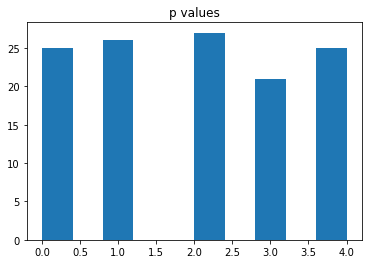

In [90]:
plt.hist(p_list)
plt.title('p values')

Text(0.5, 1.0, 'd values')

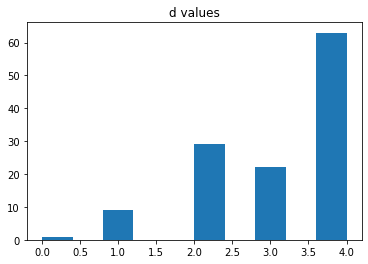

In [91]:
plt.hist(d_list)
plt.title('d values')

Text(0.5, 1.0, 'q values')

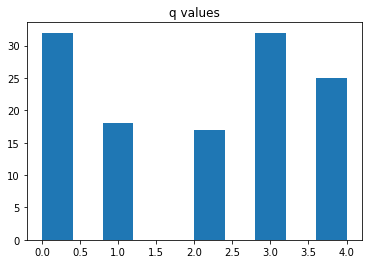

In [92]:
plt.hist(q_list)
plt.title('q values')

In [93]:
aic_list_c = []
p_list_c = []
d_list_c =[]
q_list_c = []

for batter in batters_modeled:
    aic_list_c.append(models_arima_condensed[batter][1])
    p_list_c.append(models_arima_condensed[batter][2][0])
    d_list_c.append(models_arima_condensed[batter][2][1])
    q_list_c.append(models_arima_condensed[batter][2][2])

In [94]:
print('max: ' + str(max(aic_list_c)))
print('min: ' + str(min(aic_list_c)))
print('mean: ' + str(sum(aic_list_c)/len(aic_list_c)))

max: 40.64901400501243
min: -40.28366512049449
mean: -2.5641747262102683


Text(0.5, 1.0, 'p values')

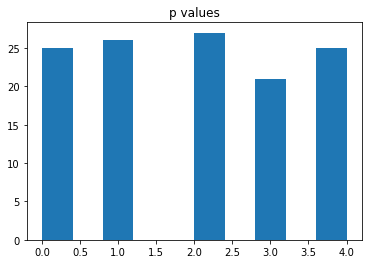

In [95]:
plt.hist(p_list_c)
plt.title('p values')

Text(0.5, 1.0, 'd values')

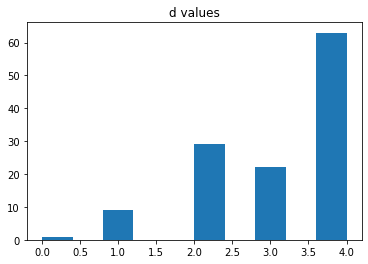

In [96]:
plt.hist(d_list_c)
plt.title('d values')

Text(0.5, 1.0, 'q values')

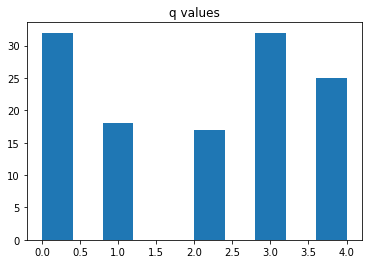

In [97]:
plt.hist(q_list_c)
plt.title('q values')

# Multivariate Time Series

Nothing new can be gatherded here, so I will skip it.

# Panel Data Approach

In [98]:
model_col = ['batter','estimated_ba_using_speedangle','play','home_team']

In [99]:
panel_train = df_train[model_col].copy()
panel_test = df_train[model_col].copy()

In [100]:
panel_train = panel_train.set_index([panel_train.index,'batter'])
panel_test = panel_test.set_index([panel_train.index,'batter'])

In [101]:
#panel_train = panel_train.fillna(0)
#panel_test = panel_test.fillna(0)

In [102]:
#panel_train['bb'] = panel_train['bb'].astype('int')
#panel_train['k'] = panel_train['k'].astype('int')
#panel_train['pa'] = panel_train['pa'].astype('int')

#panel_test['bb'] = panel_test['bb'].astype('int')
#panel_test['k'] = panel_test['k'].astype('int')
#panel_test['pa'] = panel_test['pa'].astype('int')

In [103]:
import statsmodels.api as sm

In [104]:
panel_train = sm.tools.tools.add_constant(panel_train)
panel_test = sm.tools.tools.add_constant(panel_test)

#panel_train = panel_train.T.drop_duplicates().T
#panel_test = panel_test.T.drop_duplicates().T

In [105]:
panel_train

,,const,estimated_ba_using_speedangle,play,home_team
game_date,batter,,,,
2017-04-02,575929,1.0,0.356500,1.0,12
2017-04-03,575929,1.0,0.000000,0.0,0
2017-04-04,575929,1.0,0.260000,1.0,12
2017-04-05,575929,1.0,0.000000,0.0,0
2017-04-06,575929,1.0,0.000000,0.0,0
...,...,...,...,...,...
2020-09-23,666931,1.0,0.351000,1.0,20
2020-09-24,666931,1.0,0.290000,1.0,20
2020-09-25,666931,1.0,0.061500,1.0,18


In [106]:
panel_train = panel_train.reindex()
panel_test = panel_test.reindex()

In [107]:
endog = ['play','home_team','const']

In [108]:
panel_endog = panel_train.loc[:,panel_train.columns.isin(endog)]
panel_exog = panel_train.loc[:,~panel_train.columns.isin(endog)]

In [109]:
test_panel_endog = panel_test[endog]
test_panel_exog = panel_test.loc[:,panel_test.columns!=endog[0]]

## OLS

In [110]:
ols_model = sm.OLS(panel_exog,panel_endog)
results = ols_model.fit()

In [111]:
print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     estimated_ba_using_speedangle   R-squared:                       0.573
Model:                                       OLS   Adj. R-squared:                  0.573
Method:                            Least Squares   F-statistic:                 5.764e+05
Date:                           Wed, 13 Jul 2022   Prob (F-statistic):               0.00
Time:                                   19:58:02   Log-Likelihood:             9.5463e+05
No. Observations:                         860806   AIC:                        -1.909e+06
Df Residuals:                             860803   BIC:                        -1.909e+06
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [112]:
y_pred = results.predict(panel_endog)

In [113]:
temp_df = panel_train.copy()
temp_df['pred'] = y_pred

In [114]:
mask = temp_df.play != 0
mape_res = mape(temp_df.loc[mask,'estimated_ba_using_speedangle'],temp_df.loc[mask,'pred'])
wape_res = wape(temp_df.loc[mask,'estimated_ba_using_speedangle'],temp_df.loc[mask,'pred'])

print('mape: ' + str(mape_res))
print('wape: ' + str(wape_res))

mape: 1.9727152730612367
wape: 0.6184615089531506


## Pooled OLS

In [115]:
from linearmodels import PooledOLS

In [116]:
pols_model = PooledOLS(panel_exog,panel_endog,check_rank=False)
results = pols_model.fit()

In [117]:
print(results)

                                PooledOLS Estimation Summary                               
Dep. Variable:     estimated_ba_using_speedangle   R-squared:                        0.5725
Estimator:                             PooledOLS   R-squared (Between):              0.9940
No. Observations:                         860806   R-squared (Within):               0.4945
Date:                           Wed, Jul 13 2022   R-squared (Overall):              0.5725
Time:                                   19:58:05   Log-likelihood                 9.546e+05
Cov. Estimator:                       Unadjusted                                           
                                                   F-statistic:                   5.764e+05
Entities:                                   1274   P-value                           0.0000
Avg Obs:                                  675.67   Distribution:                F(2,860803)
Min Obs:                                  66.000                                

In [118]:
y_pred = results.predict(panel_endog)

In [119]:
temp_df = panel_train.copy()
temp_df['pred'] = y_pred

In [120]:
mask = temp_df.play != 0
mape_res = mape(temp_df.loc[mask,'estimated_ba_using_speedangle'],temp_df.loc[mask,'pred'])
wape_res = wape(temp_df.loc[mask,'estimated_ba_using_speedangle'],temp_df.loc[mask,'pred'])

print('mape: ' + str(mape_res))
print('wape: ' + str(wape_res))

mape: 1.9727152730615025
wape: 0.6184615089531627


# Check Heteroskedasticity

In [121]:
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = results.predict().fitted_values
residuals_pooled_OLS = results.resids

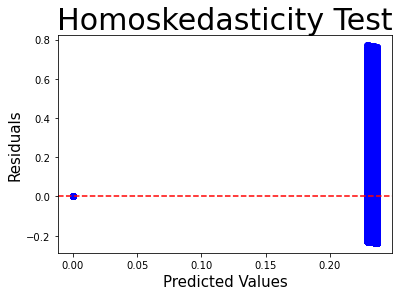

In [122]:
# 3A. Homoskedasticity

 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [123]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

pooled_OLS_dataset = pd.concat([panel_train, residuals_pooled_OLS], axis=1)
white_test_results = het_white(pooled_OLS_dataset['residual'], panel_endog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

{'LM-Stat': 184786.8022539742, 'LM p-val': 0.0, 'F-Stat': 78432.11626936897, 'F p-val': 0.0}


In [124]:
# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], panel_endog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 184785.29731540155, 'LM p-val': 0.0, 'F-Stat': 117647.0910234843, 'F p-val': 0.0}


Homoskedasticity is violated

## Auto-correlation

In [125]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.9664844163318744


There is auto-correlation. 2 is the mean.

# RE

In [126]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [127]:
# random effects model
re_model = RandomEffects(panel_exog, panel_endog,check_rank=False) 
re_res = re_model.fit() 

#print results
print(re_res)

                              RandomEffects Estimation Summary                             
Dep. Variable:     estimated_ba_using_speedangle   R-squared:                        0.5479
Estimator:                         RandomEffects   R-squared (Between):              0.9940
No. Observations:                         860806   R-squared (Within):               0.4945
Date:                           Wed, Jul 13 2022   R-squared (Overall):              0.5725
Time:                                   19:58:09   Log-likelihood                  9.55e+05
Cov. Estimator:                       Unadjusted                                           
                                                   F-statistic:                   5.217e+05
Entities:                                   1274   P-value                           0.0000
Avg Obs:                                  675.67   Distribution:                F(2,860803)
Min Obs:                                  66.000                                

In [128]:
y_pred = re_res.predict(panel_endog)

In [129]:
temp_df = panel_train.copy()
temp_df['pred'] = y_pred

In [130]:
mask = temp_df.play != 0
mape_res = mape(temp_df.loc[mask,'estimated_ba_using_speedangle'],temp_df.loc[mask,'pred'])
wape_res = wape(temp_df.loc[mask,'estimated_ba_using_speedangle'],temp_df.loc[mask,'pred'])

print('mape: ' + str(mape_res))
print('wape: ' + str(wape_res))

mape: 1.972989334547151
wape: 0.6184737866112199


# FE

In [131]:
panel_endog['home_team'] = pd.Categorical(panel_endog['home_team'])

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
# fixed effects model
fe_model = PanelOLS(panel_exog, panel_endog, entity_effects = True,check_rank=False,drop_absorbed=True) 
fe_res = fe_model.fit() 

print(fe_res)

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\linearmodels\panel\model.py:1833: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

home_team.30

  AbsorbingEffectWarning,


                                PanelOLS Estimation Summary                                
Dep. Variable:     estimated_ba_using_speedangle   R-squared:                        0.4958
Estimator:                              PanelOLS   R-squared (Between):              0.9939
No. Observations:                         860806   R-squared (Within):               0.4958
Date:                           Wed, Jul 13 2022   R-squared (Overall):              0.5736
Time:                                   19:58:17   Log-likelihood                 9.567e+05
Cov. Estimator:                       Unadjusted                                           
                                                   F-statistic:                   2.818e+04
Entities:                                   1274   P-value                           0.0000
Avg Obs:                                  675.67   Distribution:               F(30,859502)
Min Obs:                                  66.000                                

The values here in the summary already look worse than the RE model. The Random Forest approach is far better than the panel data approaches.

# Batter Results

There is quite a bit of conflicting results from the attempts at forecasting based on batter specific information. While the random forest approach concluded that recent performance does have some affect on performance of a batter, while all other time series/panel approaches conclude that there is no such result. Granted, the data as it is currently set up does not suit time series approaches due to the multiple nature, and there is not enough cross-section data for panel data approaches at this time. This means that the random forest approach is most ideal.

I have not yet tested hierarchical or neural net approaches. These might prove to be better than the other approaches.

In [133]:
h_base_df = df_train[['batter','estimated_ba_using_speedangle','play','pa']].copy()
#h_base_df_condensed = df_train[df_train.play!=0][['batter','estimated_ba_using_speedangle']].copy()

h_base_df.reset_index(inplace=True)
#h_base_df_condensed.reset_index(inplace=True)

(array([738336.,  33528.,  34647.,  25826.,  15388.,   7240.,   3008.,
          1124.,    886.,    823.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

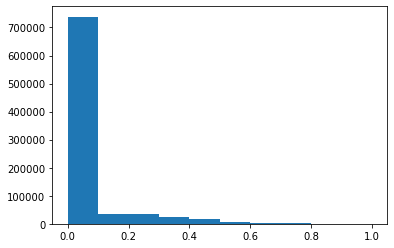

In [134]:
plt.hist(h_base_df.estimated_ba_using_speedangle)

In [135]:
h_base_df.head(5)

,game_date,batter,estimated_ba_using_speedangle,play,pa
0,2017-04-02,575929,0.3565,1.0,3.0
1,2017-04-03,575929,0.0000,0.0,0.0
2,2017-04-04,575929,0.2600,1.0,3.0
3,2017-04-05,575929,0.0000,0.0,0.0
4,2017-04-06,575929,0.0000,0.0,0.0


In [136]:
hierarchy_df_xba = h_base_df.pivot_table(index="game_date", columns="batter", values="estimated_ba_using_speedangle")
hierarchy_df_xba['total'] = hierarchy_df_xba.sum(axis=1)

hierarchy_df_play = h_base_df.pivot_table(index="game_date", columns="batter",values="play")
hierarchy_df_play['total'] = hierarchy_df_play.sum(axis=1)

h_base_df['xba_times_pa'] = h_base_df.estimated_ba_using_speedangle * h_base_df.pa
hierarchy_df_xba_weighted = h_base_df.pivot_table(index="game_date", columns="batter",values='xba_times_pa')
hierarchy_df_xba_weighted['total'] = hierarchy_df_xba_weighted.sum(axis=1)

hierarchy_df_pa = h_base_df.pivot_table(index="game_date", columns="batter",values="pa")
hierarchy_df_pa['total'] = hierarchy_df_pa.sum(axis=1)

In [137]:
hierarchy_df_xba['mean_total'] = hierarchy_df_xba['total'] / hierarchy_df_play['total']
hierarchy_df_xba_weighted['weighted_mean_total'] = hierarchy_df_xba_weighted['total'] / hierarchy_df_pa['total']

In [138]:
hierarchy_df_xba

batter,112526,134181,136860,150029,276520,282332,285079,400085,400121,400284,...,671277,671790,672386,673357,673451,676480,676606,680777,total,mean_total
game_date,,,,,,,,,,,,,,,,,,,,,
2017-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.034583,0.258100
2017-04-03,NaN,NaN,0.009000,0.12175,NaN,NaN,NaN,NaN,NaN,0.2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.705017,0.264437
2017-04-04,NaN,NaN,0.349000,0.00000,NaN,NaN,NaN,NaN,0.45825,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.365883,0.222397
2017-04-05,0.05,NaN,0.257833,0.28850,NaN,NaN,NaN,0.000,0.00000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.668229,0.216798
2017-04-06,0.00,NaN,0.143500,0.24000,NaN,NaN,NaN,0.353,0.20350,0.3054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.837767,0.243456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.095429,NaN,0.124333,0.01325,0.000000,0.000,NaN,0.031333,72.692769,0.243935
2020-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.091000,NaN,0.000000,0.00825,0.124333,0.000,NaN,0.771000,70.540383,0.247510
2020-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125000,NaN,0.190000,0.00000,0.000000,0.000,NaN,0.000000,53.482750,0.244213


In [139]:
hierarchy_df_xba_weighted

batter,112526,134181,136860,150029,276520,282332,285079,400085,400121,400284,...,671277,671790,672386,673357,673451,676480,676606,680777,total,weighted_mean_total
game_date,,,,,,,,,,,,,,,,,,,,,
2017-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.673417,0.258423
2017-04-03,NaN,NaN,0.018000,0.2435,NaN,NaN,NaN,NaN,NaN,0.2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.512333,0.276823
2017-04-04,NaN,NaN,0.349000,0.0000,NaN,NaN,NaN,NaN,0.9165,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.118333,0.241706
2017-04-05,0.1,NaN,1.031333,0.5770,NaN,NaN,NaN,0.000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.809993,0.238165
2017-04-06,0.0,NaN,0.430500,0.7200,NaN,NaN,NaN,0.353,0.6105,0.6108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.370483,0.261445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.286286,NaN,0.248667,0.0265,0.000000,0.000,NaN,0.094,216.000945,0.258684
2020-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.182000,NaN,0.000000,0.0165,0.248667,0.000,NaN,1.542,196.776450,0.263070
2020-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250000,NaN,0.570000,0.0000,0.000000,0.000,NaN,0.000,150.019633,0.252984


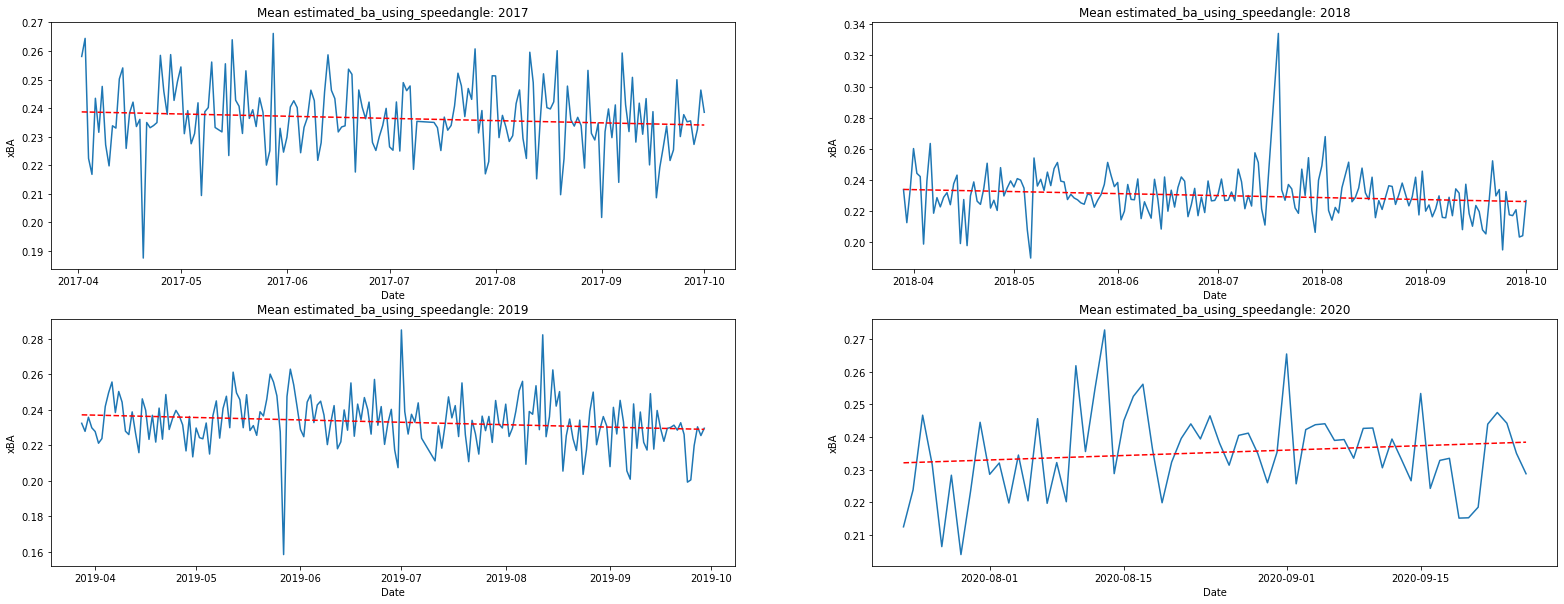

In [140]:
fig = plt.figure(figsize=(27, 10))

uniq_years = list(hierarchy_df_xba.index.year.unique())

for i in range(len(uniq_years)):
    ax=fig.add_subplot(2,2,i+1)
    plt.subplot(2, 2, i+1)
    
    x = hierarchy_df_xba[(hierarchy_df_xba.index.year == uniq_years[i]) & (hierarchy_df_xba.total != 0)]['mean_total']
    
    x_dates = hierarchy_df_xba[(hierarchy_df_xba.index.year == uniq_years[i]) & (hierarchy_df_xba.total != 0)].index
    x_num = dates.date2num(x_dates)
    
    # Calculate a fit line
    trend = np.polyfit(x_num, x, 1)
    fit = np.poly1d(trend)
    
    # General plot again
    #figure(figsize=(12, 8))
    plt.plot(x_dates, x)
    plt.xlabel('Date')
    plt.ylabel('xBA')
    
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")
    
    plt.title("Mean estimated_ba_using_speedangle: " + str(uniq_years[i]))    

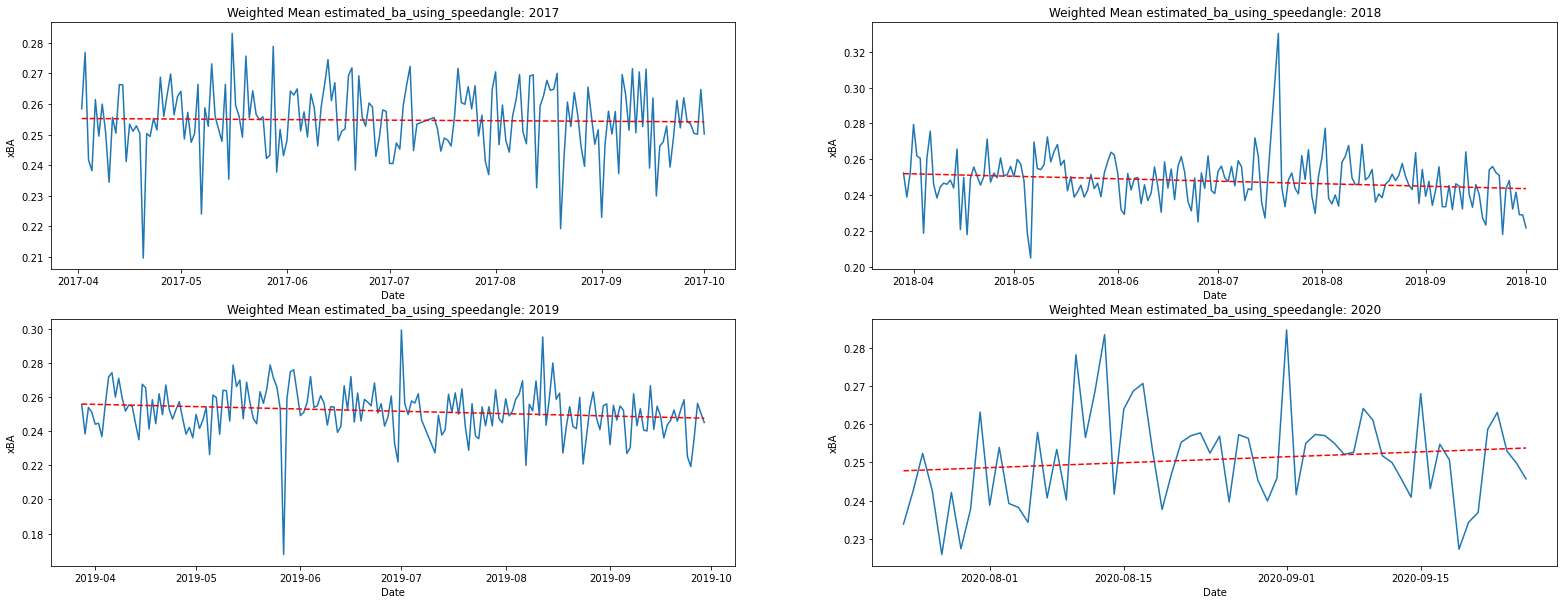

In [141]:
fig = plt.figure(figsize=(27, 10))

uniq_years = list(hierarchy_df_xba_weighted.index.year.unique())

for i in range(len(uniq_years)):
    ax=fig.add_subplot(2,2,i+1)
    plt.subplot(2, 2, i+1)
    
    x = hierarchy_df_xba_weighted[(hierarchy_df_xba_weighted.index.year == uniq_years[i]) & (hierarchy_df_xba_weighted.total != 0)]['weighted_mean_total']
    
    x_dates = hierarchy_df_xba_weighted[(hierarchy_df_xba_weighted.index.year == uniq_years[i]) & (hierarchy_df_xba_weighted.total != 0)].index
    x_num = dates.date2num(x_dates)
    
    # Calculate a fit line
    trend = np.polyfit(x_num, x, 1)
    fit = np.poly1d(trend)
    
    # General plot again
    #figure(figsize=(12, 8))
    plt.plot(x_dates, x)
    plt.xlabel('Date')
    plt.ylabel('xBA')
    
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")
    
    plt.title("Weighted Mean estimated_ba_using_speedangle: " + str(uniq_years[i]))
    #plt.plot(hierarchy_df_xba[(hierarchy_df_xba.index.year == uniq_years[i]) & (hierarchy_df_xba.total != 0)]['weighted_mean_total'])
    #plt.show()

There appears to be a general degradation of batter performance throughout the the year and a consistent pattern. There are also some interesting spikes and decreases in perofmance as well which I am unsure about.

# Depth Search

There are a few things to keep in mind going into this section. Namely that the condensed version in which we removed all instances of 'next_pa' being 0 from the training dataset and that a higher depth results in less broad range of application to players. For the purpose of focusing on recent player performance, I will remove the 'home_team' column.

The goals for mape and wape are 1.13 and 1.27 respectively. These are the scores from the 15th depth for estimated_ba_using_speedangle. Simultaneously, the goal for mse and mae are 0.018 and 0.05 each, which were from the immediately prior estimated_ba_using_speedangle.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [202]:
my_scorer = make_scorer(mape, greater_is_better=False)

def model_selection(x,params,model_type,max_depth,min_depth,depth_division=1):
    depth_values = [i for i in range(min_depth,max_depth+1) if (i % depth_division == 0)]
    
    best_params = None
    best_score = 1000000000000000
    best_depth = 0
    depth_scores_mse = []
    depth_scores_mae = []
    depth_scores_mape = []
    depth_scores_wape = []
    
    for i in depth_values:
        temp_df = depth_features(x.copy(),i)
        temp_df = temp_df.dropna(axis=0)
        
        for col in temp_df.columns:
            if ('days_off' in col) or ('play' in col):
                if col != 'next_play':
                    temp_df = temp_df.drop(col,axis=1)
                    
        mask = (temp_df.pa != 0)
        temp_df = temp_df.loc[mask,:]
        
        x_train = temp_df.loc[:,~temp_df.columns.isin(['next_estimated_ba_using_speedangle','batter'])].copy()
        y_train = temp_df['next_estimated_ba_using_speedangle'].copy()
        
        if model_type == 'rf':
            model = RandomForestRegressor()
        elif model_type == 'xgboost':
            model = XGBRegressor()
        elif model_type == 'lgbm':
            model = LGBMRegressor()
        elif model_type == 'cat':
            model = CatBoostRegressor()
        elif model_type == 'ada':
            model = AdaBoostRegressor()
        else:
            print("Not valid model")
            return
        
        #grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=False, scoring=my_scorer, n_jobs=-1)
        #grid_search.fit(x_train, y_train)
        #score = grid_search.score(x_train,y_train)
        
        model.fit(x_train,y_train)
        y_pred = model.predict(x_train)
        
        score_mse = mean_squared_error(y_train,y_pred)
        score_mae = mean_absolute_error(y_train,y_pred)
        score_mape = mape(y_train,y_pred)
        score_wape = wape(y_train,y_pred)
        
        depth_scores_mse.append(score_mse)
        depth_scores_mae.append(score_mae)
        depth_scores_mape.append(score_mape)
        depth_scores_wape.append(score_wape)
        
        print("depth completed: " + str(i))
        
        if abs(score_mse) < abs(best_score):
            #best_params = grid_search.best_params_
            best_score = score_mse
            best_depth = i
            
            #print(best_params)
            #print(best_score)
            #print(best_depth)
            
    depth_scores = {'mse': depth_scores_mse,
                    'mae': depth_scores_mae,
                    'mape': depth_scores_mape,
                    'wape': depth_scores_wape}
            
    return best_params, best_score, best_depth, depth_scores

In [203]:
final_train = pd_out.loc[:,~pd_out.columns.isin(['home_team'])].copy()
final_test = pd_test_out.loc[:,~pd_out.columns.isin(['home_team'])].copy()

In [204]:
rf_param_grid = {
     #'bootstrap': [True, False],
     'max_depth': [5,10,50,100,None],
     #'max_features': ['auto', 'sqrt'],
     #'min_samples_leaf': [1, 2, 4],
     #'min_samples_split': [2, 5, 10],
     'n_estimators': [10,30,100,300,500]}

boosting_param_grid = {
    'max_depth': [2,5,10,20],
    'n_estimators':  [10,30,100,300,500],
    'learning_rate': [0.1, 0.01, 0.05]
}

ada_boosting_param_grid = {
    'n_estimators':  [10,30,100,300,500],
    'learning_rate': [0.1, 0.01, 0.05]
}

In [222]:
print('rf')
rf_params, rf_score, rf_depth, rf_scores = model_selection(final_train,rf_param_grid,'rf',25,3,depth_division=3)

rf
depth completed: 3
depth completed: 6
depth completed: 9
depth completed: 12
depth completed: 15
depth completed: 18
depth completed: 21


D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


depth completed: 24


In [223]:
#print(rf_params)
print(rf_score)
print(rf_depth)
print(rf_scores)

0.0029608822170910723
21
{'mse': [0.0030328044072679755, 0.0029883074113489613, 0.002989379017332046, 0.0029787540373754132, 0.0029779954510571662, 0.002983341422447723, 0.0029608822170910723, 0.0029858637250964543], 'mae': [0.03580673147069357, 0.035646661035617554, 0.03559286718383423, 0.03559195650707604, 0.0356286624534089, 0.035598078621305006, 0.03553192323498878, 0.035662836382693255], 'mape': [0.8697371782864547, 0.8660210580517997, 0.8623249017699942, 0.8628610074832969, 0.8592197988245309, 0.860111699799485, 0.8588429932294055, 0.8594797082626978], 'wape': [0.21967169285665938, 0.21837935375200518, 0.21777760045114927, 0.21764287787627448, 0.217712686313688, 0.21734874007567878, 0.21696422445475189, 0.21753354441511857]}


In [224]:
print('xgb')
xgb_params, xgb_score, xgb_depth, xgb_scores = model_selection(final_train,boosting_param_grid,'xgboost',25,3,depth_division=3)

xgb
depth completed: 3
depth completed: 6
depth completed: 9
depth completed: 12
depth completed: 15
depth completed: 18
depth completed: 21


D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


depth completed: 24


In [225]:
#print(xgb_params)
print(xgb_score)
print(xgb_depth)
print(xgb_scores)

0.018073422608406053
21
{'mse': [0.019089493844200084, 0.018791202878325766, 0.018540848922010716, 0.018545434377708676, 0.018202797143703545, 0.01828847854513608, 0.018073422608406053, 0.018073848212574187], 'mae': [0.09194713861732791, 0.09175977423437018, 0.09136330269833895, 0.0914783569342535, 0.09090524298538175, 0.09124172182263707, 0.09074854492410107, 0.09084540326167759], 'mape': [1.6082849904066363, 1.6013666847109755, 1.5908037286778283, 1.592539155565755, 1.5785168851585436, 1.5844779024335618, 1.576656309361945, 1.576785444784452], 'wape': [0.5640890068373254, 0.5621407339584926, 0.5590131508139121, 0.5593851763278523, 0.5554860409432072, 0.5570883050024212, 0.5541267085274625, 0.5541321041677919]}


In [211]:
print('lgbm')
lgbm_params, lgbm_score, lgbm_depth, lgbm_scores = model_selection(final_train,boosting_param_grid,'lgbm',25,3,depth_division=3)

lgbm
depth completed: 3
depth completed: 6
depth completed: 9
depth completed: 12
depth completed: 15
depth completed: 18
depth completed: 21


D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


depth completed: 24


In [212]:
#print(lgbm_params)
print(lgbm_score)
print(lgbm_depth)
print(lgbm_scores)

0.01968865216945014
21
{'mse': [0.020206971186853086, 0.019992899770310928, 0.019936752450029942, 0.019876062133253745, 0.019771874313330155, 0.019743930169541363, 0.01968865216945014, 0.019688931708951397], 'mae': [0.09345163981153638, 0.09316276788499257, 0.09313680207781855, 0.0930021680062605, 0.09283352510180636, 0.09278856729744175, 0.09272107041772179, 0.09274127821434897], 'mape': [1.649444636883138, 1.6442239787061992, 1.6379756633049387, 1.635915172566657, 1.6295586965466606, 1.6310793840876785, 1.6293039501767603, 1.6307461095879472], 'wape': [0.5733190122207305, 0.5707357843177663, 0.5698644384404421, 0.568703198139477, 0.5672690114683125, 0.5665327730204043, 0.5661712989964417, 0.5656964226588077]}


In [213]:
print('cat')
cat_params, cat_score, cat_depth, cat_scores = model_selection(final_train,boosting_param_grid,'cat',25,3,depth_division=3)

cat
Learning rate set to 0.091843
0:	learn: 0.1769895	total: 9.42ms	remaining: 9.41s
1:	learn: 0.1717733	total: 17ms	remaining: 8.5s
2:	learn: 0.1673467	total: 24.6ms	remaining: 8.16s
3:	learn: 0.1636045	total: 32.5ms	remaining: 8.1s
4:	learn: 0.1604383	total: 42.1ms	remaining: 8.38s
5:	learn: 0.1577840	total: 49.5ms	remaining: 8.19s
6:	learn: 0.1555663	total: 57.8ms	remaining: 8.2s
7:	learn: 0.1537025	total: 65.7ms	remaining: 8.15s
8:	learn: 0.1521496	total: 75.5ms	remaining: 8.31s
9:	learn: 0.1508544	total: 83.5ms	remaining: 8.27s
10:	learn: 0.1497843	total: 99.5ms	remaining: 8.95s
11:	learn: 0.1488833	total: 107ms	remaining: 8.81s
12:	learn: 0.1481455	total: 113ms	remaining: 8.57s
13:	learn: 0.1475258	total: 121ms	remaining: 8.5s
14:	learn: 0.1470053	total: 128ms	remaining: 8.44s
15:	learn: 0.1465770	total: 136ms	remaining: 8.34s
16:	learn: 0.1462218	total: 143ms	remaining: 8.27s
17:	learn: 0.1459321	total: 151ms	remaining: 8.23s
18:	learn: 0.1456828	total: 159ms	remaining: 8.19s
19

165:	learn: 0.1436362	total: 1.26s	remaining: 6.32s
166:	learn: 0.1436314	total: 1.26s	remaining: 6.31s
167:	learn: 0.1436248	total: 1.27s	remaining: 6.3s
168:	learn: 0.1436207	total: 1.28s	remaining: 6.29s
169:	learn: 0.1436109	total: 1.29s	remaining: 6.28s
170:	learn: 0.1436080	total: 1.29s	remaining: 6.27s
171:	learn: 0.1436027	total: 1.3s	remaining: 6.26s
172:	learn: 0.1435968	total: 1.31s	remaining: 6.25s
173:	learn: 0.1435892	total: 1.31s	remaining: 6.24s
174:	learn: 0.1435803	total: 1.32s	remaining: 6.24s
175:	learn: 0.1435740	total: 1.33s	remaining: 6.23s
176:	learn: 0.1435678	total: 1.34s	remaining: 6.22s
177:	learn: 0.1435601	total: 1.34s	remaining: 6.21s
178:	learn: 0.1435527	total: 1.35s	remaining: 6.21s
179:	learn: 0.1435463	total: 1.36s	remaining: 6.2s
180:	learn: 0.1435412	total: 1.37s	remaining: 6.19s
181:	learn: 0.1435362	total: 1.37s	remaining: 6.18s
182:	learn: 0.1435295	total: 1.38s	remaining: 6.17s
183:	learn: 0.1435233	total: 1.39s	remaining: 6.16s
184:	learn: 0.1

336:	learn: 0.1426581	total: 2.54s	remaining: 4.99s
337:	learn: 0.1426539	total: 2.54s	remaining: 4.98s
338:	learn: 0.1426475	total: 2.55s	remaining: 4.98s
339:	learn: 0.1426439	total: 2.56s	remaining: 4.97s
340:	learn: 0.1426383	total: 2.57s	remaining: 4.96s
341:	learn: 0.1426334	total: 2.57s	remaining: 4.95s
342:	learn: 0.1426276	total: 2.58s	remaining: 4.95s
343:	learn: 0.1426230	total: 2.59s	remaining: 4.94s
344:	learn: 0.1426208	total: 2.6s	remaining: 4.93s
345:	learn: 0.1426159	total: 2.6s	remaining: 4.92s
346:	learn: 0.1426091	total: 2.61s	remaining: 4.91s
347:	learn: 0.1426016	total: 2.62s	remaining: 4.91s
348:	learn: 0.1425964	total: 2.62s	remaining: 4.9s
349:	learn: 0.1425935	total: 2.63s	remaining: 4.89s
350:	learn: 0.1425908	total: 2.64s	remaining: 4.88s
351:	learn: 0.1425833	total: 2.65s	remaining: 4.87s
352:	learn: 0.1425765	total: 2.65s	remaining: 4.87s
353:	learn: 0.1425739	total: 2.66s	remaining: 4.86s
354:	learn: 0.1425660	total: 2.67s	remaining: 4.86s
355:	learn: 0.1

501:	learn: 0.1418325	total: 3.81s	remaining: 3.78s
502:	learn: 0.1418265	total: 3.82s	remaining: 3.77s
503:	learn: 0.1418212	total: 3.83s	remaining: 3.76s
504:	learn: 0.1418137	total: 3.83s	remaining: 3.76s
505:	learn: 0.1418074	total: 3.84s	remaining: 3.75s
506:	learn: 0.1418032	total: 3.85s	remaining: 3.75s
507:	learn: 0.1417986	total: 3.86s	remaining: 3.74s
508:	learn: 0.1417933	total: 3.87s	remaining: 3.73s
509:	learn: 0.1417902	total: 3.88s	remaining: 3.73s
510:	learn: 0.1417837	total: 3.89s	remaining: 3.72s
511:	learn: 0.1417794	total: 3.9s	remaining: 3.71s
512:	learn: 0.1417766	total: 3.9s	remaining: 3.71s
513:	learn: 0.1417702	total: 3.91s	remaining: 3.7s
514:	learn: 0.1417678	total: 3.92s	remaining: 3.69s
515:	learn: 0.1417612	total: 3.92s	remaining: 3.68s
516:	learn: 0.1417579	total: 3.93s	remaining: 3.67s
517:	learn: 0.1417532	total: 3.94s	remaining: 3.67s
518:	learn: 0.1417516	total: 3.95s	remaining: 3.66s
519:	learn: 0.1417452	total: 3.96s	remaining: 3.65s
520:	learn: 0.1

664:	learn: 0.1410751	total: 5.07s	remaining: 2.55s
665:	learn: 0.1410703	total: 5.08s	remaining: 2.54s
666:	learn: 0.1410671	total: 5.08s	remaining: 2.54s
667:	learn: 0.1410625	total: 5.09s	remaining: 2.53s
668:	learn: 0.1410573	total: 5.1s	remaining: 2.52s
669:	learn: 0.1410533	total: 5.11s	remaining: 2.51s
670:	learn: 0.1410495	total: 5.11s	remaining: 2.51s
671:	learn: 0.1410463	total: 5.12s	remaining: 2.5s
672:	learn: 0.1410407	total: 5.13s	remaining: 2.49s
673:	learn: 0.1410341	total: 5.14s	remaining: 2.48s
674:	learn: 0.1410290	total: 5.14s	remaining: 2.48s
675:	learn: 0.1410282	total: 5.15s	remaining: 2.47s
676:	learn: 0.1410248	total: 5.16s	remaining: 2.46s
677:	learn: 0.1410189	total: 5.17s	remaining: 2.45s
678:	learn: 0.1410160	total: 5.17s	remaining: 2.45s
679:	learn: 0.1410108	total: 5.18s	remaining: 2.44s
680:	learn: 0.1410066	total: 5.19s	remaining: 2.43s
681:	learn: 0.1410012	total: 5.2s	remaining: 2.42s
682:	learn: 0.1410003	total: 5.2s	remaining: 2.41s
683:	learn: 0.14

828:	learn: 0.1403291	total: 6.32s	remaining: 1.3s
829:	learn: 0.1403221	total: 6.33s	remaining: 1.29s
830:	learn: 0.1403175	total: 6.33s	remaining: 1.29s
831:	learn: 0.1403129	total: 6.34s	remaining: 1.28s
832:	learn: 0.1403065	total: 6.35s	remaining: 1.27s
833:	learn: 0.1403002	total: 6.36s	remaining: 1.26s
834:	learn: 0.1402969	total: 6.36s	remaining: 1.26s
835:	learn: 0.1402921	total: 6.37s	remaining: 1.25s
836:	learn: 0.1402867	total: 6.38s	remaining: 1.24s
837:	learn: 0.1402817	total: 6.39s	remaining: 1.23s
838:	learn: 0.1402771	total: 6.39s	remaining: 1.23s
839:	learn: 0.1402722	total: 6.4s	remaining: 1.22s
840:	learn: 0.1402677	total: 6.41s	remaining: 1.21s
841:	learn: 0.1402623	total: 6.42s	remaining: 1.2s
842:	learn: 0.1402588	total: 6.43s	remaining: 1.2s
843:	learn: 0.1402548	total: 6.43s	remaining: 1.19s
844:	learn: 0.1402510	total: 6.44s	remaining: 1.18s
845:	learn: 0.1402493	total: 6.45s	remaining: 1.17s
846:	learn: 0.1402450	total: 6.46s	remaining: 1.17s
847:	learn: 0.14

996:	learn: 0.1396212	total: 7.59s	remaining: 22.8ms
997:	learn: 0.1396178	total: 7.6s	remaining: 15.2ms
998:	learn: 0.1396144	total: 7.61s	remaining: 7.61ms
999:	learn: 0.1396095	total: 7.61s	remaining: 0us
depth completed: 3
Learning rate set to 0.091666
0:	learn: 0.1769803	total: 41.6ms	remaining: 41.6s
1:	learn: 0.1717615	total: 52ms	remaining: 26s
2:	learn: 0.1673481	total: 58.9ms	remaining: 19.6s
3:	learn: 0.1636023	total: 68.6ms	remaining: 17.1s
4:	learn: 0.1604468	total: 79.4ms	remaining: 15.8s
5:	learn: 0.1578045	total: 85ms	remaining: 14.1s
6:	learn: 0.1555800	total: 95.4ms	remaining: 13.5s
7:	learn: 0.1537030	total: 105ms	remaining: 13s
8:	learn: 0.1521448	total: 115ms	remaining: 12.7s
9:	learn: 0.1508419	total: 124ms	remaining: 12.3s
10:	learn: 0.1497539	total: 135ms	remaining: 12.1s
11:	learn: 0.1488589	total: 144ms	remaining: 11.9s
12:	learn: 0.1481003	total: 154ms	remaining: 11.7s
13:	learn: 0.1474600	total: 165ms	remaining: 11.7s
14:	learn: 0.1469512	total: 175ms	remain

172:	learn: 0.1433386	total: 1.7s	remaining: 8.13s
173:	learn: 0.1433336	total: 1.71s	remaining: 8.12s
174:	learn: 0.1433263	total: 1.72s	remaining: 8.1s
175:	learn: 0.1433146	total: 1.73s	remaining: 8.09s
176:	learn: 0.1433118	total: 1.74s	remaining: 8.08s
177:	learn: 0.1433061	total: 1.75s	remaining: 8.06s
178:	learn: 0.1432994	total: 1.75s	remaining: 8.05s
179:	learn: 0.1432922	total: 1.76s	remaining: 8.04s
180:	learn: 0.1432831	total: 1.77s	remaining: 8.03s
181:	learn: 0.1432747	total: 1.78s	remaining: 8.01s
182:	learn: 0.1432673	total: 1.79s	remaining: 8s
183:	learn: 0.1432574	total: 1.8s	remaining: 7.99s
184:	learn: 0.1432550	total: 1.81s	remaining: 7.98s
185:	learn: 0.1432464	total: 1.82s	remaining: 7.97s
186:	learn: 0.1432382	total: 1.83s	remaining: 7.96s
187:	learn: 0.1432364	total: 1.84s	remaining: 7.94s
188:	learn: 0.1432296	total: 1.85s	remaining: 7.93s
189:	learn: 0.1432229	total: 1.86s	remaining: 7.92s
190:	learn: 0.1432124	total: 1.86s	remaining: 7.9s
191:	learn: 0.14320

336:	learn: 0.1422068	total: 3.19s	remaining: 6.27s
337:	learn: 0.1422025	total: 3.2s	remaining: 6.26s
338:	learn: 0.1421926	total: 3.21s	remaining: 6.26s
339:	learn: 0.1421838	total: 3.22s	remaining: 6.25s
340:	learn: 0.1421715	total: 3.23s	remaining: 6.24s
341:	learn: 0.1421630	total: 3.24s	remaining: 6.23s
342:	learn: 0.1421561	total: 3.25s	remaining: 6.22s
343:	learn: 0.1421482	total: 3.26s	remaining: 6.21s
344:	learn: 0.1421406	total: 3.27s	remaining: 6.2s
345:	learn: 0.1421310	total: 3.28s	remaining: 6.19s
346:	learn: 0.1421250	total: 3.29s	remaining: 6.18s
347:	learn: 0.1421181	total: 3.29s	remaining: 6.17s
348:	learn: 0.1421131	total: 3.3s	remaining: 6.16s
349:	learn: 0.1421129	total: 3.31s	remaining: 6.15s
350:	learn: 0.1421084	total: 3.32s	remaining: 6.14s
351:	learn: 0.1421024	total: 3.33s	remaining: 6.13s
352:	learn: 0.1420946	total: 3.34s	remaining: 6.12s
353:	learn: 0.1420866	total: 3.35s	remaining: 6.11s
354:	learn: 0.1420780	total: 3.36s	remaining: 6.1s
355:	learn: 0.14

498:	learn: 0.1411805	total: 4.71s	remaining: 4.73s
499:	learn: 0.1411779	total: 4.72s	remaining: 4.72s
500:	learn: 0.1411693	total: 4.73s	remaining: 4.71s
501:	learn: 0.1411645	total: 4.74s	remaining: 4.7s
502:	learn: 0.1411583	total: 4.75s	remaining: 4.69s
503:	learn: 0.1411503	total: 4.76s	remaining: 4.68s
504:	learn: 0.1411443	total: 4.76s	remaining: 4.67s
505:	learn: 0.1411377	total: 4.77s	remaining: 4.66s
506:	learn: 0.1411337	total: 4.78s	remaining: 4.65s
507:	learn: 0.1411290	total: 4.79s	remaining: 4.64s
508:	learn: 0.1411202	total: 4.8s	remaining: 4.63s
509:	learn: 0.1411170	total: 4.81s	remaining: 4.62s
510:	learn: 0.1411134	total: 4.82s	remaining: 4.61s
511:	learn: 0.1411082	total: 4.83s	remaining: 4.6s
512:	learn: 0.1411009	total: 4.84s	remaining: 4.59s
513:	learn: 0.1410927	total: 4.85s	remaining: 4.58s
514:	learn: 0.1410923	total: 4.85s	remaining: 4.57s
515:	learn: 0.1410850	total: 4.86s	remaining: 4.56s
516:	learn: 0.1410768	total: 4.87s	remaining: 4.55s
517:	learn: 0.1

658:	learn: 0.1402094	total: 6.2s	remaining: 3.21s
659:	learn: 0.1402002	total: 6.21s	remaining: 3.2s
660:	learn: 0.1401982	total: 6.22s	remaining: 3.19s
661:	learn: 0.1401956	total: 6.23s	remaining: 3.18s
662:	learn: 0.1401883	total: 6.24s	remaining: 3.17s
663:	learn: 0.1401816	total: 6.25s	remaining: 3.16s
664:	learn: 0.1401761	total: 6.26s	remaining: 3.15s
665:	learn: 0.1401701	total: 6.27s	remaining: 3.14s
666:	learn: 0.1401655	total: 6.28s	remaining: 3.13s
667:	learn: 0.1401575	total: 6.29s	remaining: 3.12s
668:	learn: 0.1401514	total: 6.3s	remaining: 3.12s
669:	learn: 0.1401450	total: 6.3s	remaining: 3.1s
670:	learn: 0.1401401	total: 6.32s	remaining: 3.1s
671:	learn: 0.1401365	total: 6.32s	remaining: 3.09s
672:	learn: 0.1401347	total: 6.33s	remaining: 3.08s
673:	learn: 0.1401334	total: 6.34s	remaining: 3.07s
674:	learn: 0.1401282	total: 6.35s	remaining: 3.06s
675:	learn: 0.1401217	total: 6.36s	remaining: 3.05s
676:	learn: 0.1401146	total: 6.37s	remaining: 3.04s
677:	learn: 0.1401

819:	learn: 0.1393609	total: 7.67s	remaining: 1.68s
820:	learn: 0.1393562	total: 7.68s	remaining: 1.68s
821:	learn: 0.1393515	total: 7.69s	remaining: 1.67s
822:	learn: 0.1393430	total: 7.7s	remaining: 1.66s
823:	learn: 0.1393370	total: 7.71s	remaining: 1.65s
824:	learn: 0.1393367	total: 7.72s	remaining: 1.64s
825:	learn: 0.1393308	total: 7.73s	remaining: 1.63s
826:	learn: 0.1393223	total: 7.74s	remaining: 1.62s
827:	learn: 0.1393177	total: 7.75s	remaining: 1.61s
828:	learn: 0.1393131	total: 7.76s	remaining: 1.6s
829:	learn: 0.1393079	total: 7.77s	remaining: 1.59s
830:	learn: 0.1393056	total: 7.78s	remaining: 1.58s
831:	learn: 0.1393024	total: 7.78s	remaining: 1.57s
832:	learn: 0.1392956	total: 7.79s	remaining: 1.56s
833:	learn: 0.1392879	total: 7.8s	remaining: 1.55s
834:	learn: 0.1392841	total: 7.81s	remaining: 1.54s
835:	learn: 0.1392798	total: 7.82s	remaining: 1.53s
836:	learn: 0.1392717	total: 7.83s	remaining: 1.52s
837:	learn: 0.1392628	total: 7.84s	remaining: 1.51s
838:	learn: 0.1

979:	learn: 0.1384416	total: 9.17s	remaining: 187ms
980:	learn: 0.1384359	total: 9.18s	remaining: 178ms
981:	learn: 0.1384317	total: 9.19s	remaining: 168ms
982:	learn: 0.1384242	total: 9.2s	remaining: 159ms
983:	learn: 0.1384185	total: 9.21s	remaining: 150ms
984:	learn: 0.1384108	total: 9.22s	remaining: 140ms
985:	learn: 0.1384040	total: 9.23s	remaining: 131ms
986:	learn: 0.1383998	total: 9.24s	remaining: 122ms
987:	learn: 0.1383942	total: 9.25s	remaining: 112ms
988:	learn: 0.1383858	total: 9.26s	remaining: 103ms
989:	learn: 0.1383816	total: 9.27s	remaining: 93.6ms
990:	learn: 0.1383753	total: 9.28s	remaining: 84.3ms
991:	learn: 0.1383711	total: 9.29s	remaining: 74.9ms
992:	learn: 0.1383635	total: 9.3s	remaining: 65.5ms
993:	learn: 0.1383585	total: 9.3s	remaining: 56.2ms
994:	learn: 0.1383529	total: 9.31s	remaining: 46.8ms
995:	learn: 0.1383471	total: 9.32s	remaining: 37.4ms
996:	learn: 0.1383431	total: 9.33s	remaining: 28.1ms
997:	learn: 0.1383358	total: 9.34s	remaining: 18.7ms
998:	l

161:	learn: 0.1434541	total: 1.69s	remaining: 8.75s
162:	learn: 0.1434453	total: 1.7s	remaining: 8.73s
163:	learn: 0.1434390	total: 1.71s	remaining: 8.72s
164:	learn: 0.1434333	total: 1.72s	remaining: 8.7s
165:	learn: 0.1434254	total: 1.73s	remaining: 8.68s
166:	learn: 0.1434179	total: 1.74s	remaining: 8.67s
167:	learn: 0.1434115	total: 1.75s	remaining: 8.65s
168:	learn: 0.1434015	total: 1.76s	remaining: 8.64s
169:	learn: 0.1433916	total: 1.77s	remaining: 8.63s
170:	learn: 0.1433843	total: 1.78s	remaining: 8.62s
171:	learn: 0.1433786	total: 1.79s	remaining: 8.6s
172:	learn: 0.1433768	total: 1.79s	remaining: 8.58s
173:	learn: 0.1433722	total: 1.8s	remaining: 8.56s
174:	learn: 0.1433611	total: 1.81s	remaining: 8.55s
175:	learn: 0.1433552	total: 1.82s	remaining: 8.53s
176:	learn: 0.1433472	total: 1.83s	remaining: 8.52s
177:	learn: 0.1433434	total: 1.84s	remaining: 8.51s
178:	learn: 0.1433397	total: 1.85s	remaining: 8.49s
179:	learn: 0.1433321	total: 1.86s	remaining: 8.48s
180:	learn: 0.14

333:	learn: 0.1423142	total: 3.37s	remaining: 6.72s
334:	learn: 0.1423082	total: 3.38s	remaining: 6.71s
335:	learn: 0.1423016	total: 3.39s	remaining: 6.71s
336:	learn: 0.1422964	total: 3.4s	remaining: 6.7s
337:	learn: 0.1422867	total: 3.42s	remaining: 6.69s
338:	learn: 0.1422810	total: 3.43s	remaining: 6.68s
339:	learn: 0.1422756	total: 3.44s	remaining: 6.67s
340:	learn: 0.1422701	total: 3.45s	remaining: 6.66s
341:	learn: 0.1422625	total: 3.46s	remaining: 6.65s
342:	learn: 0.1422523	total: 3.47s	remaining: 6.64s
343:	learn: 0.1422481	total: 3.48s	remaining: 6.63s
344:	learn: 0.1422417	total: 3.49s	remaining: 6.62s
345:	learn: 0.1422362	total: 3.5s	remaining: 6.61s
346:	learn: 0.1422294	total: 3.51s	remaining: 6.6s
347:	learn: 0.1422205	total: 3.52s	remaining: 6.59s
348:	learn: 0.1422111	total: 3.53s	remaining: 6.58s
349:	learn: 0.1422110	total: 3.54s	remaining: 6.57s
350:	learn: 0.1422058	total: 3.54s	remaining: 6.56s
351:	learn: 0.1421955	total: 3.56s	remaining: 6.55s
352:	learn: 0.14

505:	learn: 0.1411747	total: 5.08s	remaining: 4.96s
506:	learn: 0.1411667	total: 5.09s	remaining: 4.95s
507:	learn: 0.1411618	total: 5.1s	remaining: 4.94s
508:	learn: 0.1411582	total: 5.11s	remaining: 4.93s
509:	learn: 0.1411524	total: 5.12s	remaining: 4.92s
510:	learn: 0.1411524	total: 5.13s	remaining: 4.91s
511:	learn: 0.1411460	total: 5.14s	remaining: 4.9s
512:	learn: 0.1411421	total: 5.15s	remaining: 4.89s
513:	learn: 0.1411371	total: 5.16s	remaining: 4.88s
514:	learn: 0.1411308	total: 5.17s	remaining: 4.87s
515:	learn: 0.1411197	total: 5.18s	remaining: 4.86s
516:	learn: 0.1411166	total: 5.19s	remaining: 4.85s
517:	learn: 0.1411062	total: 5.2s	remaining: 4.84s
518:	learn: 0.1410974	total: 5.21s	remaining: 4.83s
519:	learn: 0.1410874	total: 5.22s	remaining: 4.82s
520:	learn: 0.1410842	total: 5.23s	remaining: 4.81s
521:	learn: 0.1410766	total: 5.24s	remaining: 4.8s
522:	learn: 0.1410665	total: 5.25s	remaining: 4.79s
523:	learn: 0.1410613	total: 5.26s	remaining: 4.78s
524:	learn: 0.14

677:	learn: 0.1400892	total: 6.78s	remaining: 3.22s
678:	learn: 0.1400825	total: 6.79s	remaining: 3.21s
679:	learn: 0.1400739	total: 6.8s	remaining: 3.2s
680:	learn: 0.1400687	total: 6.81s	remaining: 3.19s
681:	learn: 0.1400619	total: 6.82s	remaining: 3.18s
682:	learn: 0.1400556	total: 6.83s	remaining: 3.17s
683:	learn: 0.1400535	total: 6.84s	remaining: 3.16s
684:	learn: 0.1400449	total: 6.85s	remaining: 3.15s
685:	learn: 0.1400385	total: 6.86s	remaining: 3.14s
686:	learn: 0.1400298	total: 6.87s	remaining: 3.13s
687:	learn: 0.1400224	total: 6.88s	remaining: 3.12s
688:	learn: 0.1400173	total: 6.89s	remaining: 3.11s
689:	learn: 0.1400089	total: 6.9s	remaining: 3.1s
690:	learn: 0.1399993	total: 6.91s	remaining: 3.09s
691:	learn: 0.1399925	total: 6.92s	remaining: 3.08s
692:	learn: 0.1399861	total: 6.93s	remaining: 3.07s
693:	learn: 0.1399766	total: 6.94s	remaining: 3.06s
694:	learn: 0.1399661	total: 6.95s	remaining: 3.05s
695:	learn: 0.1399609	total: 6.96s	remaining: 3.04s
696:	learn: 0.13

848:	learn: 0.1389895	total: 8.5s	remaining: 1.51s
849:	learn: 0.1389860	total: 8.51s	remaining: 1.5s
850:	learn: 0.1389810	total: 8.51s	remaining: 1.49s
851:	learn: 0.1389756	total: 8.52s	remaining: 1.48s
852:	learn: 0.1389670	total: 8.54s	remaining: 1.47s
853:	learn: 0.1389625	total: 8.54s	remaining: 1.46s
854:	learn: 0.1389564	total: 8.55s	remaining: 1.45s
855:	learn: 0.1389486	total: 8.56s	remaining: 1.44s
856:	learn: 0.1389389	total: 8.58s	remaining: 1.43s
857:	learn: 0.1389318	total: 8.59s	remaining: 1.42s
858:	learn: 0.1389254	total: 8.6s	remaining: 1.41s
859:	learn: 0.1389211	total: 8.61s	remaining: 1.4s
860:	learn: 0.1389125	total: 8.62s	remaining: 1.39s
861:	learn: 0.1389031	total: 8.63s	remaining: 1.38s
862:	learn: 0.1388989	total: 8.63s	remaining: 1.37s
863:	learn: 0.1388921	total: 8.64s	remaining: 1.36s
864:	learn: 0.1388876	total: 8.65s	remaining: 1.35s
865:	learn: 0.1388857	total: 8.66s	remaining: 1.34s
866:	learn: 0.1388795	total: 8.67s	remaining: 1.33s
867:	learn: 0.13

14:	learn: 0.1470223	total: 207ms	remaining: 13.6s
15:	learn: 0.1465881	total: 220ms	remaining: 13.5s
16:	learn: 0.1462256	total: 231ms	remaining: 13.3s
17:	learn: 0.1459179	total: 244ms	remaining: 13.3s
18:	learn: 0.1456583	total: 257ms	remaining: 13.3s
19:	learn: 0.1454526	total: 267ms	remaining: 13.1s
20:	learn: 0.1452788	total: 279ms	remaining: 13s
21:	learn: 0.1451235	total: 292ms	remaining: 13s
22:	learn: 0.1450083	total: 304ms	remaining: 12.9s
23:	learn: 0.1449021	total: 316ms	remaining: 12.9s
24:	learn: 0.1448111	total: 327ms	remaining: 12.8s
25:	learn: 0.1447407	total: 339ms	remaining: 12.7s
26:	learn: 0.1446786	total: 351ms	remaining: 12.7s
27:	learn: 0.1446216	total: 364ms	remaining: 12.7s
28:	learn: 0.1445776	total: 375ms	remaining: 12.6s
29:	learn: 0.1445390	total: 388ms	remaining: 12.5s
30:	learn: 0.1445058	total: 400ms	remaining: 12.5s
31:	learn: 0.1444747	total: 412ms	remaining: 12.5s
32:	learn: 0.1444453	total: 426ms	remaining: 12.5s
33:	learn: 0.1444223	total: 440ms	r

193:	learn: 0.1431040	total: 2.33s	remaining: 9.7s
194:	learn: 0.1431036	total: 2.34s	remaining: 9.67s
195:	learn: 0.1430960	total: 2.35s	remaining: 9.66s
196:	learn: 0.1430876	total: 2.37s	remaining: 9.64s
197:	learn: 0.1430789	total: 2.38s	remaining: 9.63s
198:	learn: 0.1430705	total: 2.39s	remaining: 9.62s
199:	learn: 0.1430641	total: 2.4s	remaining: 9.6s
200:	learn: 0.1430561	total: 2.41s	remaining: 9.59s
201:	learn: 0.1430480	total: 2.42s	remaining: 9.57s
202:	learn: 0.1430397	total: 2.43s	remaining: 9.55s
203:	learn: 0.1430334	total: 2.44s	remaining: 9.54s
204:	learn: 0.1430331	total: 2.45s	remaining: 9.51s
205:	learn: 0.1430254	total: 2.46s	remaining: 9.49s
206:	learn: 0.1430159	total: 2.48s	remaining: 9.48s
207:	learn: 0.1430095	total: 2.48s	remaining: 9.46s
208:	learn: 0.1430008	total: 2.5s	remaining: 9.45s
209:	learn: 0.1429951	total: 2.51s	remaining: 9.44s
210:	learn: 0.1429873	total: 2.52s	remaining: 9.42s
211:	learn: 0.1429858	total: 2.53s	remaining: 9.4s
212:	learn: 0.142

363:	learn: 0.1419898	total: 4.25s	remaining: 7.42s
364:	learn: 0.1419792	total: 4.26s	remaining: 7.41s
365:	learn: 0.1419760	total: 4.27s	remaining: 7.4s
366:	learn: 0.1419651	total: 4.28s	remaining: 7.39s
367:	learn: 0.1419553	total: 4.3s	remaining: 7.38s
368:	learn: 0.1419548	total: 4.31s	remaining: 7.37s
369:	learn: 0.1419488	total: 4.32s	remaining: 7.35s
370:	learn: 0.1419431	total: 4.33s	remaining: 7.34s
371:	learn: 0.1419351	total: 4.34s	remaining: 7.33s
372:	learn: 0.1419279	total: 4.35s	remaining: 7.32s
373:	learn: 0.1419186	total: 4.37s	remaining: 7.31s
374:	learn: 0.1419136	total: 4.38s	remaining: 7.3s
375:	learn: 0.1419043	total: 4.39s	remaining: 7.29s
376:	learn: 0.1418931	total: 4.4s	remaining: 7.28s
377:	learn: 0.1418841	total: 4.42s	remaining: 7.27s
378:	learn: 0.1418810	total: 4.43s	remaining: 7.25s
379:	learn: 0.1418741	total: 4.44s	remaining: 7.24s
380:	learn: 0.1418630	total: 4.45s	remaining: 7.23s
381:	learn: 0.1418581	total: 4.46s	remaining: 7.22s
382:	learn: 0.14

528:	learn: 0.1408091	total: 6.18s	remaining: 5.5s
529:	learn: 0.1408020	total: 6.19s	remaining: 5.49s
530:	learn: 0.1407936	total: 6.2s	remaining: 5.47s
531:	learn: 0.1407865	total: 6.21s	remaining: 5.46s
532:	learn: 0.1407832	total: 6.22s	remaining: 5.45s
533:	learn: 0.1407780	total: 6.23s	remaining: 5.44s
534:	learn: 0.1407688	total: 6.25s	remaining: 5.43s
535:	learn: 0.1407609	total: 6.26s	remaining: 5.42s
536:	learn: 0.1407559	total: 6.27s	remaining: 5.41s
537:	learn: 0.1407484	total: 6.28s	remaining: 5.39s
538:	learn: 0.1407428	total: 6.29s	remaining: 5.38s
539:	learn: 0.1407345	total: 6.3s	remaining: 5.37s
540:	learn: 0.1407284	total: 6.32s	remaining: 5.36s
541:	learn: 0.1407275	total: 6.33s	remaining: 5.35s
542:	learn: 0.1407258	total: 6.34s	remaining: 5.33s
543:	learn: 0.1407184	total: 6.35s	remaining: 5.32s
544:	learn: 0.1407089	total: 6.36s	remaining: 5.31s
545:	learn: 0.1407010	total: 6.37s	remaining: 5.3s
546:	learn: 0.1406946	total: 6.38s	remaining: 5.29s
547:	learn: 0.14

696:	learn: 0.1397497	total: 8.1s	remaining: 3.52s
697:	learn: 0.1397387	total: 8.11s	remaining: 3.51s
698:	learn: 0.1397313	total: 8.12s	remaining: 3.5s
699:	learn: 0.1397242	total: 8.13s	remaining: 3.49s
700:	learn: 0.1397175	total: 8.15s	remaining: 3.47s
701:	learn: 0.1397109	total: 8.16s	remaining: 3.46s
702:	learn: 0.1397053	total: 8.17s	remaining: 3.45s
703:	learn: 0.1396981	total: 8.18s	remaining: 3.44s
704:	learn: 0.1396952	total: 8.19s	remaining: 3.43s
705:	learn: 0.1396928	total: 8.2s	remaining: 3.41s
706:	learn: 0.1396887	total: 8.21s	remaining: 3.4s
707:	learn: 0.1396827	total: 8.22s	remaining: 3.39s
708:	learn: 0.1396727	total: 8.24s	remaining: 3.38s
709:	learn: 0.1396654	total: 8.25s	remaining: 3.37s
710:	learn: 0.1396593	total: 8.26s	remaining: 3.36s
711:	learn: 0.1396524	total: 8.27s	remaining: 3.35s
712:	learn: 0.1396457	total: 8.28s	remaining: 3.33s
713:	learn: 0.1396420	total: 8.29s	remaining: 3.32s
714:	learn: 0.1396394	total: 8.3s	remaining: 3.31s
715:	learn: 0.139

860:	learn: 0.1386490	total: 10s	remaining: 1.62s
861:	learn: 0.1386409	total: 10s	remaining: 1.61s
862:	learn: 0.1386335	total: 10s	remaining: 1.59s
863:	learn: 0.1386261	total: 10.1s	remaining: 1.58s
864:	learn: 0.1386185	total: 10.1s	remaining: 1.57s
865:	learn: 0.1386107	total: 10.1s	remaining: 1.56s
866:	learn: 0.1386064	total: 10.1s	remaining: 1.55s
867:	learn: 0.1385991	total: 10.1s	remaining: 1.54s
868:	learn: 0.1385917	total: 10.1s	remaining: 1.53s
869:	learn: 0.1385855	total: 10.1s	remaining: 1.51s
870:	learn: 0.1385768	total: 10.1s	remaining: 1.5s
871:	learn: 0.1385749	total: 10.2s	remaining: 1.49s
872:	learn: 0.1385702	total: 10.2s	remaining: 1.48s
873:	learn: 0.1385649	total: 10.2s	remaining: 1.47s
874:	learn: 0.1385568	total: 10.2s	remaining: 1.46s
875:	learn: 0.1385447	total: 10.2s	remaining: 1.44s
876:	learn: 0.1385377	total: 10.2s	remaining: 1.43s
877:	learn: 0.1385302	total: 10.2s	remaining: 1.42s
878:	learn: 0.1385250	total: 10.2s	remaining: 1.41s
879:	learn: 0.13851

28:	learn: 0.1444992	total: 412ms	remaining: 13.8s
29:	learn: 0.1444583	total: 426ms	remaining: 13.8s
30:	learn: 0.1444271	total: 441ms	remaining: 13.8s
31:	learn: 0.1443967	total: 454ms	remaining: 13.7s
32:	learn: 0.1443709	total: 469ms	remaining: 13.7s
33:	learn: 0.1443471	total: 483ms	remaining: 13.7s
34:	learn: 0.1443302	total: 495ms	remaining: 13.6s
35:	learn: 0.1443076	total: 510ms	remaining: 13.7s
36:	learn: 0.1442880	total: 526ms	remaining: 13.7s
37:	learn: 0.1442688	total: 538ms	remaining: 13.6s
38:	learn: 0.1442553	total: 553ms	remaining: 13.6s
39:	learn: 0.1442401	total: 569ms	remaining: 13.6s
40:	learn: 0.1442236	total: 585ms	remaining: 13.7s
41:	learn: 0.1442068	total: 599ms	remaining: 13.7s
42:	learn: 0.1441911	total: 615ms	remaining: 13.7s
43:	learn: 0.1441784	total: 630ms	remaining: 13.7s
44:	learn: 0.1441661	total: 645ms	remaining: 13.7s
45:	learn: 0.1441587	total: 659ms	remaining: 13.7s
46:	learn: 0.1441490	total: 687ms	remaining: 13.9s
47:	learn: 0.1441374	total: 701

194:	learn: 0.1430455	total: 2.76s	remaining: 11.4s
195:	learn: 0.1430372	total: 2.77s	remaining: 11.4s
196:	learn: 0.1430292	total: 2.79s	remaining: 11.4s
197:	learn: 0.1430257	total: 2.8s	remaining: 11.3s
198:	learn: 0.1430136	total: 2.81s	remaining: 11.3s
199:	learn: 0.1430065	total: 2.82s	remaining: 11.3s
200:	learn: 0.1429982	total: 2.84s	remaining: 11.3s
201:	learn: 0.1429883	total: 2.85s	remaining: 11.3s
202:	learn: 0.1429880	total: 2.86s	remaining: 11.2s
203:	learn: 0.1429794	total: 2.87s	remaining: 11.2s
204:	learn: 0.1429716	total: 2.88s	remaining: 11.2s
205:	learn: 0.1429682	total: 2.9s	remaining: 11.2s
206:	learn: 0.1429618	total: 2.91s	remaining: 11.1s
207:	learn: 0.1429533	total: 2.92s	remaining: 11.1s
208:	learn: 0.1429462	total: 2.93s	remaining: 11.1s
209:	learn: 0.1429378	total: 2.94s	remaining: 11.1s
210:	learn: 0.1429376	total: 2.95s	remaining: 11s
211:	learn: 0.1429332	total: 2.97s	remaining: 11s
212:	learn: 0.1429229	total: 2.98s	remaining: 11s
213:	learn: 0.142912

362:	learn: 0.1418582	total: 4.88s	remaining: 8.56s
363:	learn: 0.1418494	total: 4.89s	remaining: 8.55s
364:	learn: 0.1418450	total: 4.91s	remaining: 8.53s
365:	learn: 0.1418440	total: 4.92s	remaining: 8.52s
366:	learn: 0.1418338	total: 4.93s	remaining: 8.51s
367:	learn: 0.1418276	total: 4.95s	remaining: 8.49s
368:	learn: 0.1418202	total: 4.96s	remaining: 8.48s
369:	learn: 0.1418091	total: 4.97s	remaining: 8.47s
370:	learn: 0.1417975	total: 4.99s	remaining: 8.46s
371:	learn: 0.1417901	total: 5s	remaining: 8.45s
372:	learn: 0.1417845	total: 5.02s	remaining: 8.44s
373:	learn: 0.1417786	total: 5.03s	remaining: 8.42s
374:	learn: 0.1417697	total: 5.05s	remaining: 8.42s
375:	learn: 0.1417639	total: 5.07s	remaining: 8.41s
376:	learn: 0.1417542	total: 5.08s	remaining: 8.4s
377:	learn: 0.1417461	total: 5.1s	remaining: 8.39s
378:	learn: 0.1417346	total: 5.11s	remaining: 8.38s
379:	learn: 0.1417344	total: 5.12s	remaining: 8.36s
380:	learn: 0.1417319	total: 5.13s	remaining: 8.34s
381:	learn: 0.141

522:	learn: 0.1406613	total: 7.01s	remaining: 6.4s
523:	learn: 0.1406600	total: 7.02s	remaining: 6.38s
524:	learn: 0.1406564	total: 7.04s	remaining: 6.37s
525:	learn: 0.1406510	total: 7.05s	remaining: 6.35s
526:	learn: 0.1406444	total: 7.06s	remaining: 6.34s
527:	learn: 0.1406427	total: 7.07s	remaining: 6.32s
528:	learn: 0.1406336	total: 7.09s	remaining: 6.31s
529:	learn: 0.1406275	total: 7.1s	remaining: 6.3s
530:	learn: 0.1406216	total: 7.12s	remaining: 6.28s
531:	learn: 0.1406112	total: 7.13s	remaining: 6.27s
532:	learn: 0.1406089	total: 7.14s	remaining: 6.26s
533:	learn: 0.1406002	total: 7.15s	remaining: 6.24s
534:	learn: 0.1405933	total: 7.17s	remaining: 6.23s
535:	learn: 0.1405862	total: 7.18s	remaining: 6.21s
536:	learn: 0.1405772	total: 7.19s	remaining: 6.2s
537:	learn: 0.1405705	total: 7.21s	remaining: 6.19s
538:	learn: 0.1405655	total: 7.22s	remaining: 6.17s
539:	learn: 0.1405636	total: 7.23s	remaining: 6.16s
540:	learn: 0.1405556	total: 7.24s	remaining: 6.15s
541:	learn: 0.14

684:	learn: 0.1395093	total: 9.14s	remaining: 4.2s
685:	learn: 0.1395041	total: 9.15s	remaining: 4.19s
686:	learn: 0.1394940	total: 9.17s	remaining: 4.18s
687:	learn: 0.1394880	total: 9.18s	remaining: 4.16s
688:	learn: 0.1394801	total: 9.19s	remaining: 4.15s
689:	learn: 0.1394699	total: 9.21s	remaining: 4.14s
690:	learn: 0.1394649	total: 9.22s	remaining: 4.12s
691:	learn: 0.1394541	total: 9.24s	remaining: 4.11s
692:	learn: 0.1394500	total: 9.25s	remaining: 4.1s
693:	learn: 0.1394387	total: 9.26s	remaining: 4.08s
694:	learn: 0.1394320	total: 9.28s	remaining: 4.07s
695:	learn: 0.1394238	total: 9.29s	remaining: 4.06s
696:	learn: 0.1394121	total: 9.3s	remaining: 4.04s
697:	learn: 0.1394050	total: 9.32s	remaining: 4.03s
698:	learn: 0.1393993	total: 9.33s	remaining: 4.02s
699:	learn: 0.1393900	total: 9.34s	remaining: 4s
700:	learn: 0.1393804	total: 9.36s	remaining: 3.99s
701:	learn: 0.1393753	total: 9.37s	remaining: 3.98s
702:	learn: 0.1393640	total: 9.38s	remaining: 3.96s
703:	learn: 0.1393

844:	learn: 0.1384140	total: 11.2s	remaining: 2.06s
845:	learn: 0.1384083	total: 11.3s	remaining: 2.05s
846:	learn: 0.1383997	total: 11.3s	remaining: 2.04s
847:	learn: 0.1383945	total: 11.3s	remaining: 2.02s
848:	learn: 0.1383867	total: 11.3s	remaining: 2.01s
849:	learn: 0.1383814	total: 11.3s	remaining: 2s
850:	learn: 0.1383755	total: 11.3s	remaining: 1.98s
851:	learn: 0.1383695	total: 11.3s	remaining: 1.97s
852:	learn: 0.1383666	total: 11.4s	remaining: 1.96s
853:	learn: 0.1383605	total: 11.4s	remaining: 1.94s
854:	learn: 0.1383537	total: 11.4s	remaining: 1.93s
855:	learn: 0.1383493	total: 11.4s	remaining: 1.92s
856:	learn: 0.1383421	total: 11.4s	remaining: 1.9s
857:	learn: 0.1383340	total: 11.4s	remaining: 1.89s
858:	learn: 0.1383277	total: 11.4s	remaining: 1.88s
859:	learn: 0.1383196	total: 11.4s	remaining: 1.86s
860:	learn: 0.1383129	total: 11.5s	remaining: 1.85s
861:	learn: 0.1383041	total: 11.5s	remaining: 1.84s
862:	learn: 0.1382965	total: 11.5s	remaining: 1.82s
863:	learn: 0.13

11:	learn: 0.1489058	total: 210ms	remaining: 17.3s
12:	learn: 0.1481367	total: 228ms	remaining: 17.3s
13:	learn: 0.1474961	total: 243ms	remaining: 17.1s
14:	learn: 0.1469598	total: 259ms	remaining: 17s
15:	learn: 0.1465202	total: 276ms	remaining: 17s
16:	learn: 0.1461624	total: 291ms	remaining: 16.9s
17:	learn: 0.1458596	total: 307ms	remaining: 16.7s
18:	learn: 0.1456012	total: 323ms	remaining: 16.7s
19:	learn: 0.1453854	total: 342ms	remaining: 16.7s
20:	learn: 0.1452058	total: 359ms	remaining: 16.8s
21:	learn: 0.1450570	total: 376ms	remaining: 16.7s
22:	learn: 0.1449323	total: 392ms	remaining: 16.7s
23:	learn: 0.1448221	total: 410ms	remaining: 16.7s
24:	learn: 0.1447347	total: 430ms	remaining: 16.8s
25:	learn: 0.1446573	total: 447ms	remaining: 16.8s
26:	learn: 0.1445913	total: 466ms	remaining: 16.8s
27:	learn: 0.1445363	total: 483ms	remaining: 16.8s
28:	learn: 0.1444897	total: 500ms	remaining: 16.7s
29:	learn: 0.1444474	total: 518ms	remaining: 16.7s
30:	learn: 0.1444113	total: 535ms	r

187:	learn: 0.1431304	total: 2.79s	remaining: 12s
188:	learn: 0.1431300	total: 2.8s	remaining: 12s
189:	learn: 0.1431175	total: 2.81s	remaining: 12s
190:	learn: 0.1431128	total: 2.82s	remaining: 12s
191:	learn: 0.1431044	total: 2.83s	remaining: 11.9s
192:	learn: 0.1430955	total: 2.85s	remaining: 11.9s
193:	learn: 0.1430859	total: 2.86s	remaining: 11.9s
194:	learn: 0.1430725	total: 2.87s	remaining: 11.9s
195:	learn: 0.1430678	total: 2.89s	remaining: 11.8s
196:	learn: 0.1430594	total: 2.9s	remaining: 11.8s
197:	learn: 0.1430532	total: 2.91s	remaining: 11.8s
198:	learn: 0.1430464	total: 2.94s	remaining: 11.8s
199:	learn: 0.1430336	total: 2.95s	remaining: 11.8s
200:	learn: 0.1430231	total: 2.96s	remaining: 11.8s
201:	learn: 0.1430152	total: 2.98s	remaining: 11.8s
202:	learn: 0.1430148	total: 2.99s	remaining: 11.7s
203:	learn: 0.1430050	total: 3s	remaining: 11.7s
204:	learn: 0.1429951	total: 3.02s	remaining: 11.7s
205:	learn: 0.1429858	total: 3.03s	remaining: 11.7s
206:	learn: 0.1429737	tot

349:	learn: 0.1419499	total: 4.95s	remaining: 9.18s
350:	learn: 0.1419466	total: 4.96s	remaining: 9.17s
351:	learn: 0.1419384	total: 4.97s	remaining: 9.15s
352:	learn: 0.1419294	total: 4.99s	remaining: 9.14s
353:	learn: 0.1419199	total: 5s	remaining: 9.13s
354:	learn: 0.1419123	total: 5.01s	remaining: 9.11s
355:	learn: 0.1419026	total: 5.03s	remaining: 9.1s
356:	learn: 0.1419024	total: 5.04s	remaining: 9.08s
357:	learn: 0.1418968	total: 5.05s	remaining: 9.06s
358:	learn: 0.1418914	total: 5.06s	remaining: 9.04s
359:	learn: 0.1418852	total: 5.08s	remaining: 9.03s
360:	learn: 0.1418782	total: 5.09s	remaining: 9.01s
361:	learn: 0.1418738	total: 5.1s	remaining: 8.99s
362:	learn: 0.1418636	total: 5.12s	remaining: 8.98s
363:	learn: 0.1418575	total: 5.13s	remaining: 8.97s
364:	learn: 0.1418500	total: 5.15s	remaining: 8.96s
365:	learn: 0.1418475	total: 5.16s	remaining: 8.94s
366:	learn: 0.1418416	total: 5.17s	remaining: 8.93s
367:	learn: 0.1418331	total: 5.19s	remaining: 8.91s
368:	learn: 0.141

522:	learn: 0.1406326	total: 7.32s	remaining: 6.67s
523:	learn: 0.1406230	total: 7.33s	remaining: 6.66s
524:	learn: 0.1406140	total: 7.34s	remaining: 6.64s
525:	learn: 0.1406105	total: 7.36s	remaining: 6.63s
526:	learn: 0.1406012	total: 7.37s	remaining: 6.62s
527:	learn: 0.1405929	total: 7.38s	remaining: 6.6s
528:	learn: 0.1405859	total: 7.4s	remaining: 6.59s
529:	learn: 0.1405750	total: 7.41s	remaining: 6.57s
530:	learn: 0.1405662	total: 7.42s	remaining: 6.56s
531:	learn: 0.1405554	total: 7.44s	remaining: 6.54s
532:	learn: 0.1405488	total: 7.46s	remaining: 6.53s
533:	learn: 0.1405408	total: 7.47s	remaining: 6.52s
534:	learn: 0.1405329	total: 7.48s	remaining: 6.5s
535:	learn: 0.1405283	total: 7.5s	remaining: 6.49s
536:	learn: 0.1405194	total: 7.51s	remaining: 6.47s
537:	learn: 0.1405111	total: 7.52s	remaining: 6.46s
538:	learn: 0.1405000	total: 7.54s	remaining: 6.45s
539:	learn: 0.1404874	total: 7.55s	remaining: 6.43s
540:	learn: 0.1404797	total: 7.57s	remaining: 6.42s
541:	learn: 0.14

692:	learn: 0.1393806	total: 9.65s	remaining: 4.28s
693:	learn: 0.1393712	total: 9.67s	remaining: 4.26s
694:	learn: 0.1393655	total: 9.68s	remaining: 4.25s
695:	learn: 0.1393561	total: 9.69s	remaining: 4.23s
696:	learn: 0.1393497	total: 9.71s	remaining: 4.22s
697:	learn: 0.1393426	total: 9.72s	remaining: 4.21s
698:	learn: 0.1393383	total: 9.73s	remaining: 4.19s
699:	learn: 0.1393320	total: 9.75s	remaining: 4.18s
700:	learn: 0.1393249	total: 9.76s	remaining: 4.16s
701:	learn: 0.1393190	total: 9.78s	remaining: 4.15s
702:	learn: 0.1393126	total: 9.79s	remaining: 4.14s
703:	learn: 0.1393077	total: 9.8s	remaining: 4.12s
704:	learn: 0.1392997	total: 9.82s	remaining: 4.11s
705:	learn: 0.1392927	total: 9.83s	remaining: 4.09s
706:	learn: 0.1392859	total: 9.84s	remaining: 4.08s
707:	learn: 0.1392792	total: 9.86s	remaining: 4.07s
708:	learn: 0.1392686	total: 9.87s	remaining: 4.05s
709:	learn: 0.1392622	total: 9.89s	remaining: 4.04s
710:	learn: 0.1392508	total: 9.9s	remaining: 4.03s
711:	learn: 0.

860:	learn: 0.1381879	total: 12s	remaining: 1.94s
861:	learn: 0.1381795	total: 12s	remaining: 1.92s
862:	learn: 0.1381724	total: 12s	remaining: 1.91s
863:	learn: 0.1381634	total: 12s	remaining: 1.9s
864:	learn: 0.1381583	total: 12.1s	remaining: 1.88s
865:	learn: 0.1381533	total: 12.1s	remaining: 1.87s
866:	learn: 0.1381430	total: 12.1s	remaining: 1.85s
867:	learn: 0.1381379	total: 12.1s	remaining: 1.84s
868:	learn: 0.1381304	total: 12.1s	remaining: 1.83s
869:	learn: 0.1381187	total: 12.1s	remaining: 1.81s
870:	learn: 0.1381084	total: 12.1s	remaining: 1.8s
871:	learn: 0.1381023	total: 12.2s	remaining: 1.78s
872:	learn: 0.1380973	total: 12.2s	remaining: 1.77s
873:	learn: 0.1380887	total: 12.2s	remaining: 1.76s
874:	learn: 0.1380814	total: 12.2s	remaining: 1.74s
875:	learn: 0.1380763	total: 12.2s	remaining: 1.73s
876:	learn: 0.1380682	total: 12.2s	remaining: 1.72s
877:	learn: 0.1380598	total: 12.3s	remaining: 1.7s
878:	learn: 0.1380529	total: 12.3s	remaining: 1.69s
879:	learn: 0.1380466	t

22:	learn: 0.1449376	total: 426ms	remaining: 18.1s
23:	learn: 0.1448280	total: 444ms	remaining: 18.1s
24:	learn: 0.1447373	total: 462ms	remaining: 18s
25:	learn: 0.1446688	total: 479ms	remaining: 17.9s
26:	learn: 0.1446011	total: 497ms	remaining: 17.9s
27:	learn: 0.1445443	total: 514ms	remaining: 17.9s
28:	learn: 0.1444973	total: 533ms	remaining: 17.9s
29:	learn: 0.1444568	total: 552ms	remaining: 17.8s
30:	learn: 0.1444174	total: 570ms	remaining: 17.8s
31:	learn: 0.1443883	total: 602ms	remaining: 18.2s
32:	learn: 0.1443561	total: 627ms	remaining: 18.4s
33:	learn: 0.1443278	total: 644ms	remaining: 18.3s
34:	learn: 0.1443029	total: 660ms	remaining: 18.2s
35:	learn: 0.1442840	total: 678ms	remaining: 18.1s
36:	learn: 0.1442662	total: 695ms	remaining: 18.1s
37:	learn: 0.1442484	total: 725ms	remaining: 18.3s
38:	learn: 0.1442338	total: 743ms	remaining: 18.3s
39:	learn: 0.1442173	total: 758ms	remaining: 18.2s
40:	learn: 0.1442035	total: 774ms	remaining: 18.1s
41:	learn: 0.1441861	total: 792ms

185:	learn: 0.1430494	total: 3s	remaining: 13.2s
186:	learn: 0.1430430	total: 3.02s	remaining: 13.1s
187:	learn: 0.1430303	total: 3.04s	remaining: 13.1s
188:	learn: 0.1430235	total: 3.05s	remaining: 13.1s
189:	learn: 0.1430232	total: 3.06s	remaining: 13s
190:	learn: 0.1430089	total: 3.07s	remaining: 13s
191:	learn: 0.1430015	total: 3.09s	remaining: 13s
192:	learn: 0.1429907	total: 3.1s	remaining: 13s
193:	learn: 0.1429871	total: 3.12s	remaining: 13s
194:	learn: 0.1429867	total: 3.13s	remaining: 12.9s
195:	learn: 0.1429864	total: 3.14s	remaining: 12.9s
196:	learn: 0.1429786	total: 3.15s	remaining: 12.8s
197:	learn: 0.1429720	total: 3.17s	remaining: 12.8s
198:	learn: 0.1429637	total: 3.18s	remaining: 12.8s
199:	learn: 0.1429562	total: 3.2s	remaining: 12.8s
200:	learn: 0.1429455	total: 3.21s	remaining: 12.8s
201:	learn: 0.1429370	total: 3.23s	remaining: 12.8s
202:	learn: 0.1429291	total: 3.24s	remaining: 12.7s
203:	learn: 0.1429190	total: 3.26s	remaining: 12.7s
204:	learn: 0.1429136	total

356:	learn: 0.1416935	total: 5.61s	remaining: 10.1s
357:	learn: 0.1416871	total: 5.62s	remaining: 10.1s
358:	learn: 0.1416809	total: 5.64s	remaining: 10.1s
359:	learn: 0.1416754	total: 5.65s	remaining: 10s
360:	learn: 0.1416676	total: 5.67s	remaining: 10s
361:	learn: 0.1416586	total: 5.68s	remaining: 10s
362:	learn: 0.1416557	total: 5.7s	remaining: 10s
363:	learn: 0.1416444	total: 5.71s	remaining: 9.98s
364:	learn: 0.1416351	total: 5.73s	remaining: 9.97s
365:	learn: 0.1416229	total: 5.75s	remaining: 9.96s
366:	learn: 0.1416184	total: 5.76s	remaining: 9.94s
367:	learn: 0.1416112	total: 5.78s	remaining: 9.92s
368:	learn: 0.1415986	total: 5.79s	remaining: 9.91s
369:	learn: 0.1415925	total: 5.81s	remaining: 9.89s
370:	learn: 0.1415844	total: 5.82s	remaining: 9.88s
371:	learn: 0.1415745	total: 5.84s	remaining: 9.86s
372:	learn: 0.1415685	total: 5.86s	remaining: 9.85s
373:	learn: 0.1415645	total: 5.87s	remaining: 9.82s
374:	learn: 0.1415543	total: 5.88s	remaining: 9.81s
375:	learn: 0.1415436

524:	learn: 0.1404001	total: 8.21s	remaining: 7.42s
525:	learn: 0.1403915	total: 8.22s	remaining: 7.41s
526:	learn: 0.1403913	total: 8.23s	remaining: 7.39s
527:	learn: 0.1403867	total: 8.25s	remaining: 7.37s
528:	learn: 0.1403809	total: 8.26s	remaining: 7.35s
529:	learn: 0.1403749	total: 8.28s	remaining: 7.34s
530:	learn: 0.1403685	total: 8.29s	remaining: 7.32s
531:	learn: 0.1403585	total: 8.31s	remaining: 7.31s
532:	learn: 0.1403510	total: 8.32s	remaining: 7.29s
533:	learn: 0.1403401	total: 8.34s	remaining: 7.28s
534:	learn: 0.1403318	total: 8.35s	remaining: 7.26s
535:	learn: 0.1403269	total: 8.37s	remaining: 7.25s
536:	learn: 0.1403212	total: 8.38s	remaining: 7.23s
537:	learn: 0.1403126	total: 8.4s	remaining: 7.21s
538:	learn: 0.1403059	total: 8.41s	remaining: 7.2s
539:	learn: 0.1402978	total: 8.43s	remaining: 7.18s
540:	learn: 0.1402906	total: 8.45s	remaining: 7.17s
541:	learn: 0.1402825	total: 8.46s	remaining: 7.15s
542:	learn: 0.1402728	total: 8.48s	remaining: 7.13s
543:	learn: 0.

692:	learn: 0.1391673	total: 10.8s	remaining: 4.77s
693:	learn: 0.1391663	total: 10.8s	remaining: 4.76s
694:	learn: 0.1391568	total: 10.8s	remaining: 4.74s
695:	learn: 0.1391507	total: 10.8s	remaining: 4.73s
696:	learn: 0.1391407	total: 10.8s	remaining: 4.71s
697:	learn: 0.1391360	total: 10.9s	remaining: 4.7s
698:	learn: 0.1391313	total: 10.9s	remaining: 4.68s
699:	learn: 0.1391230	total: 10.9s	remaining: 4.66s
700:	learn: 0.1391204	total: 10.9s	remaining: 4.64s
701:	learn: 0.1391131	total: 10.9s	remaining: 4.63s
702:	learn: 0.1391036	total: 10.9s	remaining: 4.62s
703:	learn: 0.1390954	total: 10.9s	remaining: 4.6s
704:	learn: 0.1390875	total: 11s	remaining: 4.58s
705:	learn: 0.1390822	total: 11s	remaining: 4.57s
706:	learn: 0.1390730	total: 11s	remaining: 4.55s
707:	learn: 0.1390674	total: 11s	remaining: 4.54s
708:	learn: 0.1390575	total: 11s	remaining: 4.52s
709:	learn: 0.1390466	total: 11s	remaining: 4.51s
710:	learn: 0.1390371	total: 11.1s	remaining: 4.49s
711:	learn: 0.1390324	tota

857:	learn: 0.1379681	total: 13.4s	remaining: 2.21s
858:	learn: 0.1379597	total: 13.4s	remaining: 2.19s
859:	learn: 0.1379530	total: 13.4s	remaining: 2.18s
860:	learn: 0.1379470	total: 13.4s	remaining: 2.16s
861:	learn: 0.1379424	total: 13.4s	remaining: 2.15s
862:	learn: 0.1379379	total: 13.4s	remaining: 2.13s
863:	learn: 0.1379297	total: 13.5s	remaining: 2.12s
864:	learn: 0.1379220	total: 13.5s	remaining: 2.1s
865:	learn: 0.1379129	total: 13.5s	remaining: 2.09s
866:	learn: 0.1379057	total: 13.5s	remaining: 2.07s
867:	learn: 0.1378938	total: 13.5s	remaining: 2.06s
868:	learn: 0.1378877	total: 13.5s	remaining: 2.04s
869:	learn: 0.1378875	total: 13.5s	remaining: 2.02s
870:	learn: 0.1378780	total: 13.6s	remaining: 2.01s
871:	learn: 0.1378731	total: 13.6s	remaining: 1.99s
872:	learn: 0.1378677	total: 13.6s	remaining: 1.98s
873:	learn: 0.1378610	total: 13.6s	remaining: 1.96s
874:	learn: 0.1378563	total: 13.6s	remaining: 1.95s
875:	learn: 0.1378481	total: 13.6s	remaining: 1.93s
876:	learn: 0

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


Learning rate set to 0.090878
0:	learn: 0.1771603	total: 20.3ms	remaining: 20.3s
1:	learn: 0.1719741	total: 38.2ms	remaining: 19s
2:	learn: 0.1675576	total: 58.3ms	remaining: 19.4s
3:	learn: 0.1638114	total: 78.1ms	remaining: 19.5s
4:	learn: 0.1606449	total: 96.4ms	remaining: 19.2s
5:	learn: 0.1579692	total: 116ms	remaining: 19.2s
6:	learn: 0.1557259	total: 135ms	remaining: 19.1s
7:	learn: 0.1538606	total: 145ms	remaining: 18s
8:	learn: 0.1522938	total: 161ms	remaining: 17.7s
9:	learn: 0.1509717	total: 178ms	remaining: 17.7s
10:	learn: 0.1498693	total: 197ms	remaining: 17.7s
11:	learn: 0.1489463	total: 215ms	remaining: 17.7s
12:	learn: 0.1481822	total: 234ms	remaining: 17.8s
13:	learn: 0.1475493	total: 251ms	remaining: 17.7s
14:	learn: 0.1470159	total: 270ms	remaining: 17.7s
15:	learn: 0.1465702	total: 291ms	remaining: 17.9s
16:	learn: 0.1461959	total: 313ms	remaining: 18.1s
17:	learn: 0.1458858	total: 336ms	remaining: 18.3s
18:	learn: 0.1456293	total: 355ms	remaining: 18.3s
19:	learn:

164:	learn: 0.1432232	total: 2.81s	remaining: 14.2s
165:	learn: 0.1432186	total: 2.82s	remaining: 14.2s
166:	learn: 0.1432102	total: 2.84s	remaining: 14.2s
167:	learn: 0.1432058	total: 2.88s	remaining: 14.3s
168:	learn: 0.1432054	total: 2.89s	remaining: 14.2s
169:	learn: 0.1431951	total: 2.91s	remaining: 14.2s
170:	learn: 0.1431946	total: 2.92s	remaining: 14.2s
171:	learn: 0.1431874	total: 2.94s	remaining: 14.2s
172:	learn: 0.1431783	total: 2.96s	remaining: 14.1s
173:	learn: 0.1431779	total: 2.97s	remaining: 14.1s
174:	learn: 0.1431705	total: 2.98s	remaining: 14.1s
175:	learn: 0.1431611	total: 3s	remaining: 14s
176:	learn: 0.1431550	total: 3.01s	remaining: 14s
177:	learn: 0.1431442	total: 3.03s	remaining: 14s
178:	learn: 0.1431321	total: 3.05s	remaining: 14s
179:	learn: 0.1431239	total: 3.06s	remaining: 13.9s
180:	learn: 0.1431136	total: 3.08s	remaining: 13.9s
181:	learn: 0.1431132	total: 3.09s	remaining: 13.9s
182:	learn: 0.1431040	total: 3.1s	remaining: 13.9s
183:	learn: 0.1430927	to

326:	learn: 0.1419402	total: 5.34s	remaining: 11s
327:	learn: 0.1419288	total: 5.36s	remaining: 11s
328:	learn: 0.1419163	total: 5.38s	remaining: 11s
329:	learn: 0.1419105	total: 5.39s	remaining: 11s
330:	learn: 0.1419038	total: 5.41s	remaining: 10.9s
331:	learn: 0.1418980	total: 5.42s	remaining: 10.9s
332:	learn: 0.1418895	total: 5.44s	remaining: 10.9s
333:	learn: 0.1418791	total: 5.46s	remaining: 10.9s
334:	learn: 0.1418697	total: 5.47s	remaining: 10.9s
335:	learn: 0.1418631	total: 5.49s	remaining: 10.8s
336:	learn: 0.1418501	total: 5.5s	remaining: 10.8s
337:	learn: 0.1418394	total: 5.52s	remaining: 10.8s
338:	learn: 0.1418292	total: 5.54s	remaining: 10.8s
339:	learn: 0.1418239	total: 5.56s	remaining: 10.8s
340:	learn: 0.1418237	total: 5.57s	remaining: 10.8s
341:	learn: 0.1418164	total: 5.59s	remaining: 10.8s
342:	learn: 0.1418056	total: 5.61s	remaining: 10.7s
343:	learn: 0.1418000	total: 5.62s	remaining: 10.7s
344:	learn: 0.1417896	total: 5.64s	remaining: 10.7s
345:	learn: 0.1417844

489:	learn: 0.1407693	total: 7.9s	remaining: 8.23s
490:	learn: 0.1407613	total: 7.92s	remaining: 8.21s
491:	learn: 0.1407543	total: 7.94s	remaining: 8.19s
492:	learn: 0.1407497	total: 7.95s	remaining: 8.18s
493:	learn: 0.1407412	total: 7.97s	remaining: 8.16s
494:	learn: 0.1407343	total: 7.99s	remaining: 8.15s
495:	learn: 0.1407270	total: 8s	remaining: 8.13s
496:	learn: 0.1407159	total: 8.02s	remaining: 8.11s
497:	learn: 0.1407106	total: 8.03s	remaining: 8.1s
498:	learn: 0.1407053	total: 8.04s	remaining: 8.08s
499:	learn: 0.1406963	total: 8.06s	remaining: 8.06s
500:	learn: 0.1406877	total: 8.08s	remaining: 8.04s
501:	learn: 0.1406807	total: 8.09s	remaining: 8.03s
502:	learn: 0.1406735	total: 8.11s	remaining: 8.01s
503:	learn: 0.1406716	total: 8.12s	remaining: 7.99s
504:	learn: 0.1406636	total: 8.14s	remaining: 7.98s
505:	learn: 0.1406574	total: 8.15s	remaining: 7.96s
506:	learn: 0.1406503	total: 8.17s	remaining: 7.95s
507:	learn: 0.1406427	total: 8.19s	remaining: 7.93s
508:	learn: 0.140

659:	learn: 0.1395113	total: 10.7s	remaining: 5.49s
660:	learn: 0.1395044	total: 10.7s	remaining: 5.48s
661:	learn: 0.1394978	total: 10.7s	remaining: 5.46s
662:	learn: 0.1394954	total: 10.7s	remaining: 5.44s
663:	learn: 0.1394897	total: 10.7s	remaining: 5.43s
664:	learn: 0.1394814	total: 10.7s	remaining: 5.41s
665:	learn: 0.1394735	total: 10.8s	remaining: 5.4s
666:	learn: 0.1394673	total: 10.8s	remaining: 5.38s
667:	learn: 0.1394587	total: 10.8s	remaining: 5.36s
668:	learn: 0.1394500	total: 10.8s	remaining: 5.35s
669:	learn: 0.1394426	total: 10.8s	remaining: 5.33s
670:	learn: 0.1394365	total: 10.8s	remaining: 5.32s
671:	learn: 0.1394307	total: 10.9s	remaining: 5.3s
672:	learn: 0.1394242	total: 10.9s	remaining: 5.29s
673:	learn: 0.1394146	total: 10.9s	remaining: 5.27s
674:	learn: 0.1394088	total: 10.9s	remaining: 5.25s
675:	learn: 0.1393988	total: 10.9s	remaining: 5.24s
676:	learn: 0.1393915	total: 11s	remaining: 5.22s
677:	learn: 0.1393859	total: 11s	remaining: 5.21s
678:	learn: 0.1393

830:	learn: 0.1382437	total: 13.5s	remaining: 2.74s
831:	learn: 0.1382367	total: 13.5s	remaining: 2.72s
832:	learn: 0.1382271	total: 13.5s	remaining: 2.71s
833:	learn: 0.1382223	total: 13.5s	remaining: 2.69s
834:	learn: 0.1382171	total: 13.5s	remaining: 2.67s
835:	learn: 0.1382115	total: 13.5s	remaining: 2.66s
836:	learn: 0.1382018	total: 13.6s	remaining: 2.64s
837:	learn: 0.1381953	total: 13.6s	remaining: 2.63s
838:	learn: 0.1381852	total: 13.6s	remaining: 2.61s
839:	learn: 0.1381795	total: 13.6s	remaining: 2.59s
840:	learn: 0.1381707	total: 13.6s	remaining: 2.58s
841:	learn: 0.1381608	total: 13.6s	remaining: 2.56s
842:	learn: 0.1381545	total: 13.7s	remaining: 2.54s
843:	learn: 0.1381425	total: 13.7s	remaining: 2.53s
844:	learn: 0.1381364	total: 13.7s	remaining: 2.51s
845:	learn: 0.1381244	total: 13.7s	remaining: 2.5s
846:	learn: 0.1381181	total: 13.7s	remaining: 2.48s
847:	learn: 0.1381100	total: 13.8s	remaining: 2.46s
848:	learn: 0.1381007	total: 13.8s	remaining: 2.45s
849:	learn: 0

998:	learn: 0.1369683	total: 16.3s	remaining: 16.3ms
999:	learn: 0.1369595	total: 16.3s	remaining: 0us
depth completed: 24


In [214]:
#print(cat_params)
print(cat_score)
print(cat_depth)
print(cat_scores)

0.018757897891186558
24
{'mse': [0.019490816020713755, 0.019133708270260747, 0.019075204523213377, 0.018962791572454254, 0.018874319065897253, 0.01882257865414427, 0.018777797053195964, 0.018757897891186558], 'mae': [0.09305621340129644, 0.09255537926692393, 0.09258272363402051, 0.09244289628750352, 0.09240265304559865, 0.09230741504593669, 0.09228292885867317, 0.09229104088267795], 'mape': [1.6229316672093876, 1.6159284626974508, 1.6092887478212188, 1.6055793730313888, 1.6000711942571573, 1.5997386005225223, 1.6013927787002757, 1.6016652597126175], 'wape': [0.5708930999587097, 0.5670147868936983, 0.5664742683445964, 0.5652832820030634, 0.5646361224863826, 0.5635950348137526, 0.5634959289374754, 0.5629500981226603]}


In [215]:
print('ada')
ada_params, ada_score, ada_depth, ada_scores = model_selection(final_train,ada_boosting_param_grid,'ada',25,3,depth_division=3)

ada
depth completed: 3
depth completed: 6
depth completed: 9
depth completed: 12
depth completed: 15
depth completed: 18
depth completed: 21


D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


depth completed: 24


In [216]:
#print(ada_params)
print(ada_score)
print(ada_depth)
print(ada_scores)

0.021403413794428342
6
{'mse': [0.02148683783313417, 0.021403413794428342, 0.021477404808508276, 0.02148776777145988, 0.021460482770034862, 0.021505565467738304, 0.02144998355230894, 0.02150912796558346], 'mae': [0.09771453993922471, 0.09748138083762535, 0.09773929067296744, 0.09778264552005528, 0.09774923968299676, 0.09793256879891399, 0.09772396856559018, 0.09794565459391624], 'mape': [1.8346400830170833, 1.8269097324543409, 1.8290469408313355, 1.8306665435147944, 1.8251215949332735, 1.831486635647332, 1.8240241062130491, 1.83371205693894], 'wape': [0.5994715944047426, 0.5971925653542469, 0.5980251066209068, 0.597935558083451, 0.5973070020334041, 0.5979401491652296, 0.5967198822943344, 0.5974416946323796]}


In [217]:
print('Random Forest: ' + str(rf_score))
print('XGBoost: ' + str(xgb_score))
print('LightGBM: ' + str(lgbm_score))
print('CatBoost: ' + str(cat_score))
print('AdaBoost: ' + str(ada_score))

Random Forest: 0.0029717384660830582
XGBoost: 0.018073422608406053
LightGBM: 0.01968865216945014
CatBoost: 0.018757897891186558
AdaBoost: 0.021403413794428342


In [221]:
rf_scores

[0.866830569716252,
 0.8665328478617402,
 0.8637360392460562,
 0.861952666367458,
 0.8587360528982874,
 0.8600484891910102,
 0.8607361281445066,
 0.859777385223005]

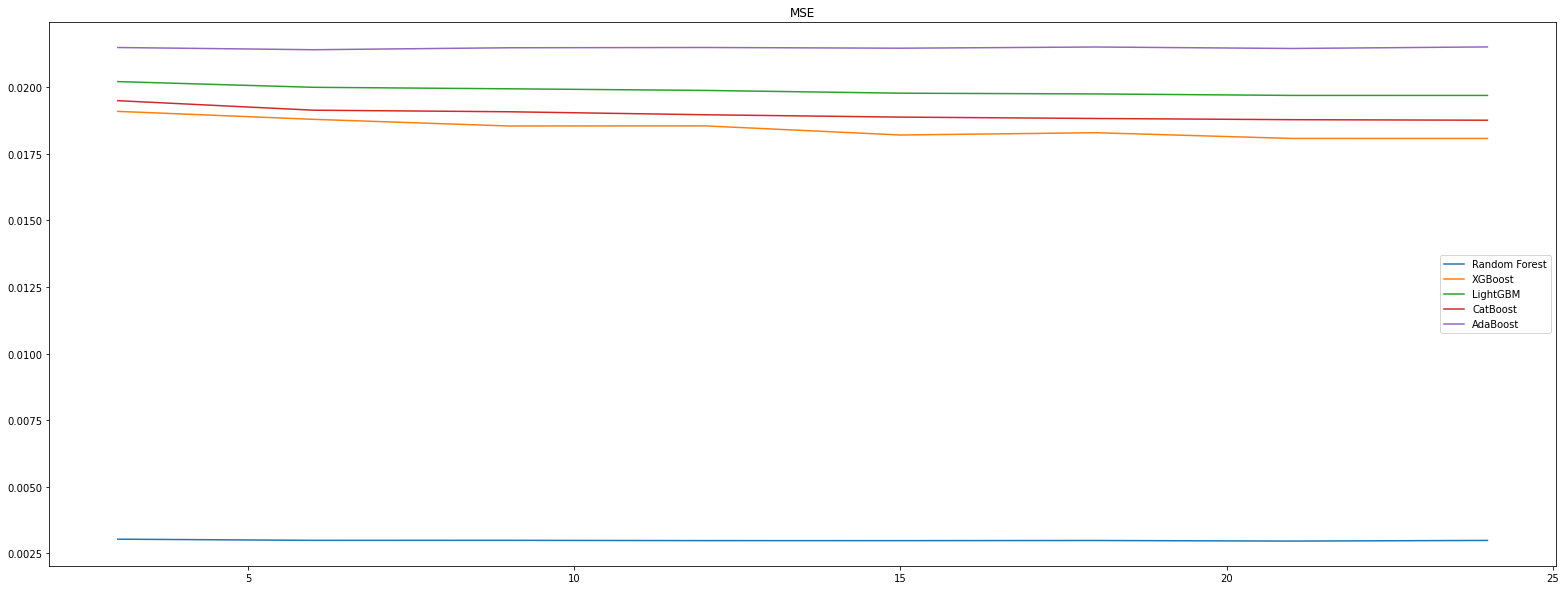

In [226]:
fig = plt.figure(figsize=(27, 10))

plt.plot([int(i*3) for i in range(1,len(rf_scores['mse'])+1)],rf_scores['mse'],label="Random Forest")
plt.plot([int(i*3) for i in range(1,len(xgb_scores['mse'])+1)],xgb_scores['mse'],label="XGBoost")
plt.plot([int(i*3) for i in range(1,len(lgbm_scores['mse'])+1)],lgbm_scores['mse'],label="LightGBM")
plt.plot([int(i*3) for i in range(1,len(cat_scores['mse'])+1)],cat_scores['mse'],label="CatBoost")
plt.plot([int(i*3) for i in range(1,len(ada_scores['mse'])+1)],ada_scores['mse'],label="AdaBoost")
plt.title('MSE')

plt.legend()

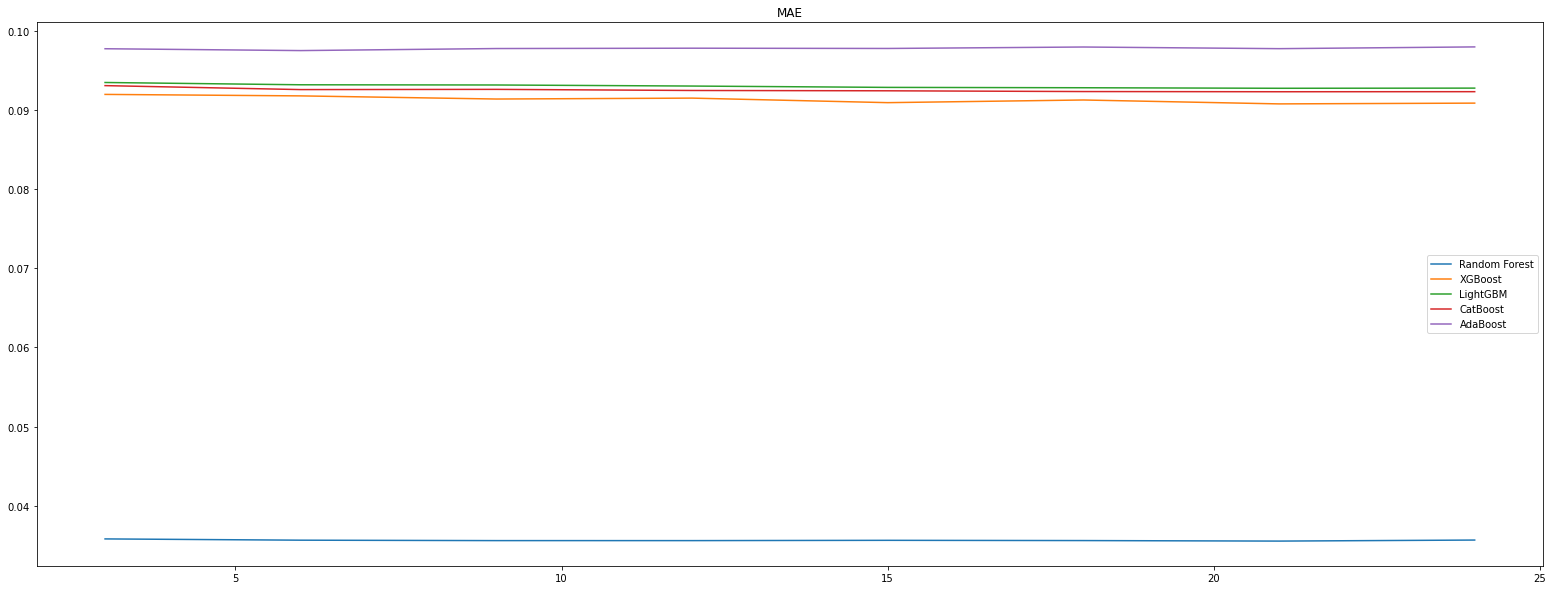

In [228]:
fig = plt.figure(figsize=(27, 10))

plt.plot([int(i*3) for i in range(1,len(rf_scores['mae'])+1)],rf_scores['mae'],label="Random Forest")
plt.plot([int(i*3) for i in range(1,len(xgb_scores['mae'])+1)],xgb_scores['mae'],label="XGBoost")
plt.plot([int(i*3) for i in range(1,len(lgbm_scores['mae'])+1)],lgbm_scores['mae'],label="LightGBM")
plt.plot([int(i*3) for i in range(1,len(cat_scores['mae'])+1)],cat_scores['mae'],label="CatBoost")
plt.plot([int(i*3) for i in range(1,len(ada_scores['mae'])+1)],ada_scores['mae'],label="AdaBoost")
plt.title('MAE')

plt.legend()

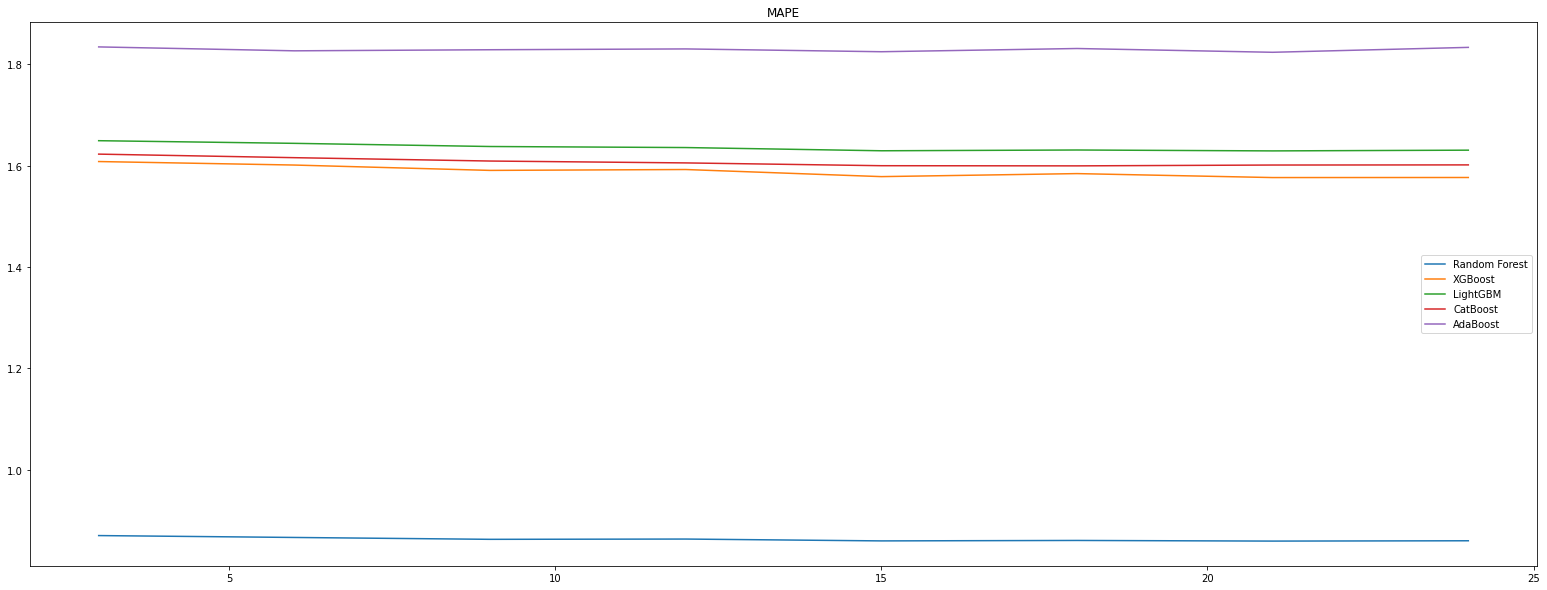

In [229]:
fig = plt.figure(figsize=(27, 10))

plt.plot([int(i*3) for i in range(1,len(rf_scores['mape'])+1)],rf_scores['mape'],label="Random Forest")
plt.plot([int(i*3) for i in range(1,len(xgb_scores['mape'])+1)],xgb_scores['mape'],label="XGBoost")
plt.plot([int(i*3) for i in range(1,len(lgbm_scores['mape'])+1)],lgbm_scores['mape'],label="LightGBM")
plt.plot([int(i*3) for i in range(1,len(cat_scores['mape'])+1)],cat_scores['mape'],label="CatBoost")
plt.plot([int(i*3) for i in range(1,len(ada_scores['mape'])+1)],ada_scores['mape'],label="AdaBoost")
plt.title('MAPE')

plt.legend()

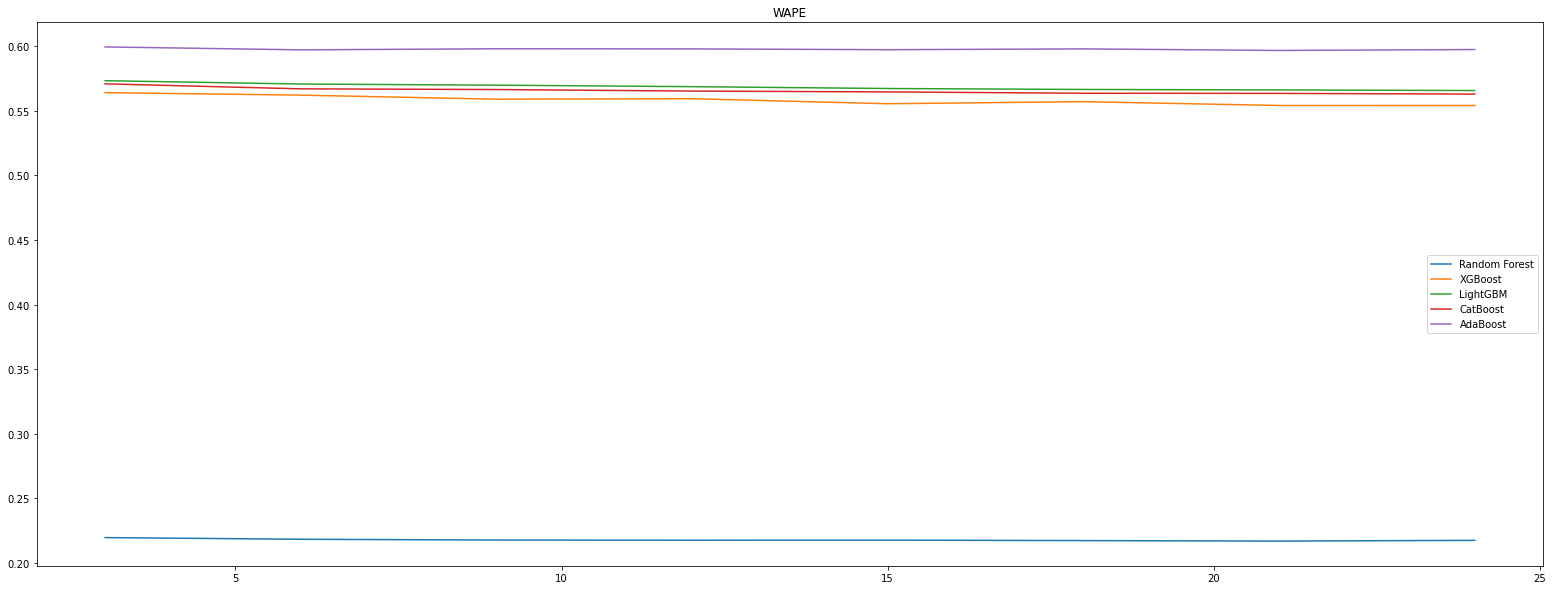

In [230]:
fig = plt.figure(figsize=(27, 10))

plt.plot([int(i*3) for i in range(1,len(rf_scores['wape'])+1)],rf_scores['wape'],label="Random Forest")
plt.plot([int(i*3) for i in range(1,len(xgb_scores['wape'])+1)],xgb_scores['wape'],label="XGBoost")
plt.plot([int(i*3) for i in range(1,len(lgbm_scores['wape'])+1)],lgbm_scores['wape'],label="LightGBM")
plt.plot([int(i*3) for i in range(1,len(cat_scores['wape'])+1)],cat_scores['wape'],label="CatBoost")
plt.plot([int(i*3) for i in range(1,len(ada_scores['wape'])+1)],ada_scores['wape'],label="AdaBoost")
plt.title('WAPE')

plt.legend()

Despite previous discovery, depth 15 appears to be the best depth. While I was intending to cap depth to 15 or 20 depending on meaningful difference, there does not seem to be much benefit to increasing depth, despite previous feature analysis using random forest generators assuming that deeper depths returned more relevant rolling means. An alternative would be to include career averages to simulate highest depths, while keeping recent events at a lower depth for the purpose of mapping recent performance. However, the results are slightly better at higher depths and random forest is clealry the best performing at the default settings.

Before doing this, I will test the data as is at depth 15.

## On Test Set

In [233]:
depth = 10

In [234]:
train_df = depth_features(final_train.copy(),depth)
train_df = train_df.dropna(axis=0)
        
for col in train_df.columns:
    if ('days_off' in col) or ('play' in col):
        if col != 'next_play':
            train_df = train_df.drop(col,axis=1)
            
mask = (train_df.pa != 0)
train_df = train_df.loc[mask,:]

In [235]:
test_df = depth_features(final_test.copy(),depth)
test_df = test_df.dropna(axis=0)
        
for col in test_df.columns:
    if ('days_off' in col) or ('play' in col):
        if col != 'next_play':
            test_df = test_df.drop(col,axis=1)
            
mask = (test_df.pa != 0)
test_df = test_df.loc[mask,:]

In [236]:
x_train = train_df.loc[:,~train_df.columns.isin(['next_estimated_ba_using_speedangle','batter'])].copy()
y_train = train_df['next_estimated_ba_using_speedangle'].copy()

In [237]:
x_test = test_df.loc[:,~test_df.columns.isin(['next_estimated_ba_using_speedangle','batter'])].copy()
y_test = test_df['next_estimated_ba_using_speedangle'].copy()

In [238]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train,y_train)

RandomForestRegressor()

In [239]:
xgb_model = XGBRegressor()
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [240]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train,y_train)

LGBMRegressor()

In [241]:
cat_model = CatBoostRegressor()
cat_model.fit(x_train,y_train)

Learning rate set to 0.091487
0:	learn: 0.1770332	total: 37.4ms	remaining: 37.4s
1:	learn: 0.1718394	total: 49.1ms	remaining: 24.5s
2:	learn: 0.1674335	total: 59.1ms	remaining: 19.6s
3:	learn: 0.1636881	total: 70ms	remaining: 17.4s
4:	learn: 0.1605242	total: 82.1ms	remaining: 16.3s
5:	learn: 0.1578496	total: 94.9ms	remaining: 15.7s
6:	learn: 0.1556211	total: 106ms	remaining: 15s
7:	learn: 0.1537673	total: 116ms	remaining: 14.4s
8:	learn: 0.1521975	total: 127ms	remaining: 14s
9:	learn: 0.1508976	total: 138ms	remaining: 13.6s
10:	learn: 0.1498116	total: 148ms	remaining: 13.3s
11:	learn: 0.1489097	total: 155ms	remaining: 12.8s
12:	learn: 0.1481564	total: 166ms	remaining: 12.6s
13:	learn: 0.1475245	total: 177ms	remaining: 12.5s
14:	learn: 0.1470003	total: 187ms	remaining: 12.3s
15:	learn: 0.1465628	total: 198ms	remaining: 12.2s
16:	learn: 0.1461996	total: 209ms	remaining: 12.1s
17:	learn: 0.1458914	total: 221ms	remaining: 12.1s
18:	learn: 0.1456387	total: 232ms	remaining: 12s
19:	learn: 0.

175:	learn: 0.1432932	total: 1.89s	remaining: 8.84s
176:	learn: 0.1432882	total: 1.9s	remaining: 8.83s
177:	learn: 0.1432775	total: 1.91s	remaining: 8.82s
178:	learn: 0.1432678	total: 1.92s	remaining: 8.81s
179:	learn: 0.1432664	total: 1.93s	remaining: 8.79s
180:	learn: 0.1432577	total: 1.94s	remaining: 8.78s
181:	learn: 0.1432476	total: 1.95s	remaining: 8.77s
182:	learn: 0.1432414	total: 1.96s	remaining: 8.75s
183:	learn: 0.1432377	total: 1.97s	remaining: 8.73s
184:	learn: 0.1432333	total: 1.98s	remaining: 8.72s
185:	learn: 0.1432200	total: 1.99s	remaining: 8.71s
186:	learn: 0.1432091	total: 2s	remaining: 8.71s
187:	learn: 0.1432067	total: 2.01s	remaining: 8.69s
188:	learn: 0.1431992	total: 2.02s	remaining: 8.67s
189:	learn: 0.1431874	total: 2.03s	remaining: 8.66s
190:	learn: 0.1431821	total: 2.04s	remaining: 8.65s
191:	learn: 0.1431730	total: 2.05s	remaining: 8.64s
192:	learn: 0.1431687	total: 2.06s	remaining: 8.62s
193:	learn: 0.1431596	total: 2.07s	remaining: 8.61s
194:	learn: 0.14

342:	learn: 0.1421531	total: 3.59s	remaining: 6.88s
343:	learn: 0.1421530	total: 3.6s	remaining: 6.86s
344:	learn: 0.1421450	total: 3.61s	remaining: 6.85s
345:	learn: 0.1421363	total: 3.62s	remaining: 6.84s
346:	learn: 0.1421362	total: 3.63s	remaining: 6.83s
347:	learn: 0.1421271	total: 3.64s	remaining: 6.82s
348:	learn: 0.1421191	total: 3.65s	remaining: 6.81s
349:	learn: 0.1421105	total: 3.66s	remaining: 6.8s
350:	learn: 0.1421014	total: 3.67s	remaining: 6.79s
351:	learn: 0.1420957	total: 3.68s	remaining: 6.78s
352:	learn: 0.1420827	total: 3.69s	remaining: 6.77s
353:	learn: 0.1420738	total: 3.71s	remaining: 6.76s
354:	learn: 0.1420644	total: 3.71s	remaining: 6.75s
355:	learn: 0.1420556	total: 3.73s	remaining: 6.74s
356:	learn: 0.1420481	total: 3.73s	remaining: 6.73s
357:	learn: 0.1420400	total: 3.75s	remaining: 6.72s
358:	learn: 0.1420320	total: 3.75s	remaining: 6.71s
359:	learn: 0.1420239	total: 3.77s	remaining: 6.7s
360:	learn: 0.1420169	total: 3.77s	remaining: 6.68s
361:	learn: 0.1

508:	learn: 0.1409795	total: 5.29s	remaining: 5.1s
509:	learn: 0.1409771	total: 5.29s	remaining: 5.09s
510:	learn: 0.1409677	total: 5.31s	remaining: 5.08s
511:	learn: 0.1409569	total: 5.32s	remaining: 5.07s
512:	learn: 0.1409483	total: 5.33s	remaining: 5.06s
513:	learn: 0.1409428	total: 5.34s	remaining: 5.05s
514:	learn: 0.1409351	total: 5.35s	remaining: 5.04s
515:	learn: 0.1409282	total: 5.36s	remaining: 5.03s
516:	learn: 0.1409191	total: 5.37s	remaining: 5.02s
517:	learn: 0.1409102	total: 5.38s	remaining: 5s
518:	learn: 0.1409005	total: 5.39s	remaining: 5s
519:	learn: 0.1408956	total: 5.4s	remaining: 4.98s
520:	learn: 0.1408848	total: 5.41s	remaining: 4.97s
521:	learn: 0.1408848	total: 5.42s	remaining: 4.96s
522:	learn: 0.1408767	total: 5.43s	remaining: 4.95s
523:	learn: 0.1408652	total: 5.44s	remaining: 4.94s
524:	learn: 0.1408651	total: 5.45s	remaining: 4.93s
525:	learn: 0.1408612	total: 5.46s	remaining: 4.92s
526:	learn: 0.1408536	total: 5.46s	remaining: 4.91s
527:	learn: 0.140850

672:	learn: 0.1398759	total: 6.99s	remaining: 3.4s
673:	learn: 0.1398730	total: 7s	remaining: 3.38s
674:	learn: 0.1398688	total: 7.01s	remaining: 3.37s
675:	learn: 0.1398622	total: 7.02s	remaining: 3.36s
676:	learn: 0.1398546	total: 7.03s	remaining: 3.35s
677:	learn: 0.1398545	total: 7.04s	remaining: 3.34s
678:	learn: 0.1398489	total: 7.05s	remaining: 3.33s
679:	learn: 0.1398441	total: 7.06s	remaining: 3.32s
680:	learn: 0.1398371	total: 7.07s	remaining: 3.31s
681:	learn: 0.1398259	total: 7.08s	remaining: 3.3s
682:	learn: 0.1398194	total: 7.09s	remaining: 3.29s
683:	learn: 0.1398132	total: 7.1s	remaining: 3.28s
684:	learn: 0.1398057	total: 7.11s	remaining: 3.27s
685:	learn: 0.1398015	total: 7.12s	remaining: 3.26s
686:	learn: 0.1397983	total: 7.13s	remaining: 3.25s
687:	learn: 0.1397919	total: 7.14s	remaining: 3.24s
688:	learn: 0.1397848	total: 7.15s	remaining: 3.23s
689:	learn: 0.1397776	total: 7.16s	remaining: 3.22s
690:	learn: 0.1397733	total: 7.17s	remaining: 3.21s
691:	learn: 0.1397

835:	learn: 0.1389049	total: 8.67s	remaining: 1.7s
836:	learn: 0.1388980	total: 8.68s	remaining: 1.69s
837:	learn: 0.1388884	total: 8.69s	remaining: 1.68s
838:	learn: 0.1388808	total: 8.7s	remaining: 1.67s
839:	learn: 0.1388748	total: 8.71s	remaining: 1.66s
840:	learn: 0.1388690	total: 8.72s	remaining: 1.65s
841:	learn: 0.1388620	total: 8.73s	remaining: 1.64s
842:	learn: 0.1388583	total: 8.74s	remaining: 1.63s
843:	learn: 0.1388542	total: 8.75s	remaining: 1.62s
844:	learn: 0.1388515	total: 8.76s	remaining: 1.61s
845:	learn: 0.1388439	total: 8.77s	remaining: 1.6s
846:	learn: 0.1388352	total: 8.78s	remaining: 1.59s
847:	learn: 0.1388243	total: 8.79s	remaining: 1.58s
848:	learn: 0.1388171	total: 8.8s	remaining: 1.57s
849:	learn: 0.1388150	total: 8.81s	remaining: 1.55s
850:	learn: 0.1388110	total: 8.82s	remaining: 1.54s
851:	learn: 0.1388048	total: 8.83s	remaining: 1.53s
852:	learn: 0.1387969	total: 8.84s	remaining: 1.52s
853:	learn: 0.1387913	total: 8.85s	remaining: 1.51s
854:	learn: 0.13

999:	learn: 0.1378753	total: 10.4s	remaining: 0us


In [242]:
ada_model = AdaBoostRegressor()
ada_model.fit(x_train,y_train)

AdaBoostRegressor()

In [243]:
print("Random Forest")
print("   mape: " + str(mape(y_test,rf_model.predict(x_test))))
print("   wape: " + str(wape(y_test,rf_model.predict(x_test))))
print("   mse: " + str(mean_squared_error(y_test,rf_model.predict(x_test))))
print("   mae: " + str(mean_absolute_error(y_test,rf_model.predict(x_test))))

print("XGBoost")
print("   mape: " + str(mape(y_test,xgb_model.predict(x_test))))
print("   wape: " + str(wape(y_test,xgb_model.predict(x_test))))
print("   mse: " + str(mean_squared_error(y_test,xgb_model.predict(x_test))))
print("   mae: " + str(mean_absolute_error(y_test,xgb_model.predict(x_test))))

print("LightGBM")
print("   mape: " + str(mape(y_test,lgbm_model.predict(x_test))))
print("   wape: " + str(wape(y_test,lgbm_model.predict(x_test))))
print("   mse: " + str(mean_squared_error(y_test,lgbm_model.predict(x_test))))
print("   mae: " + str(mean_absolute_error(y_test,lgbm_model.predict(x_test))))

print("CatBoost")
print("   mape: " + str(mape(y_test,cat_model.predict(x_test))))
print("   wape: " + str(wape(y_test,cat_model.predict(x_test))))
print("   mse: " + str(mean_squared_error(y_test,cat_model.predict(x_test))))
print("   mae: " + str(mean_absolute_error(y_test,cat_model.predict(x_test))))

print("AdaBoost")
print("   mape: " + str(mape(y_test,ada_model.predict(x_test))))
print("   wape: " + str(wape(y_test,ada_model.predict(x_test))))
print("   mse: " + str(mean_squared_error(y_test,ada_model.predict(x_test))))
print("   mae: " + str(mean_absolute_error(y_test,ada_model.predict(x_test))))

Random Forest
   mape: 2.2164463804190646
   wape: 0.5836803049245137
   mse: 0.020940839468360672
   mae: 0.09527948308554189
XGBoost
   mape: 2.164903186838496
   wape: 0.5982371618933577
   mse: 0.02100292209945923
   mae: 0.09765573219938
LightGBM
   mape: 2.1504379040931747
   wape: 0.5783245391931747
   mse: 0.02052068537947586
   mae: 0.09440521238272072
CatBoost
   mape: 2.154397515212705
   wape: 0.5911185849710289
   mse: 0.020663053877236204
   mae: 0.09649370167729156
AdaBoost
   mape: 2.377673023383871
   wape: 0.5933865461359581
   mse: 0.02111227388680189
   mae: 0.09686392175432584


Although Random Forest is not the best performing model on the test set, it is by far the best on the training set. Despite concerns of overtuning, I will select this model due to time limitation. I understand Random Forest better and I have time limitations set by the nature of the project. I will train a random forest model for batter performance, and will more than likely do the same for pitchers. This will allow me to perform more intensive work later, and focus on producing a working model that will inform me of the validity of the feature engineering I must do.

# Random Forest Tuning

In [245]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [247]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_test = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_test, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(ite

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [253]:
pred_train = rf_random.predict(x_train)
pred_test = rf_random.predict(x_test)

In [254]:
print("Random Forest: Train Set")
print("   mape: " + str(mape(y_train,pred_train)))
print("   wape: " + str(wape(y_train,pred_train)))
print("   mse: " + str(mean_squared_error(y_train,pred_train)))
print("   mae: " + str(mean_absolute_error(y_train,pred_train)))

Random Forest: Train Set
   mape: 1.646069911607354
   wape: 0.5699546999281233
   mse: 0.0200674928818681
   mae: 0.09316155314795092


In [255]:
print("Random Forest: Test Set")
print("   mape: " + str(mape(y_test,pred_test)))
print("   wape: " + str(wape(y_test,pred_test)))
print("   mse: " + str(mean_squared_error(y_test,pred_test)))
print("   mae: " + str(mean_absolute_error(y_test,pred_test)))

Random Forest: Test Set
   mape: 2.1546963837486817
   wape: 0.5750368428871685
   mse: 0.02047976212076408
   mae: 0.09386853159713376


In [252]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

The improvements in the model are very minimal on the test set, and all tested models are essentially the same. However, this model is slightly better.

In [251]:
import pickle as pkl

In [269]:
with open(r"models/batter_recent_performance.pkl", "wb") as output_file:
    pkl.dump(rf_random, output_file)